In [1]:
# Now combine the work of One Period and No Hodlers; have multiple periods where if we are in the high state, 
# we may keep growing next period, while in the low state, we stop growing but also add hodlers to population.

# Set U(X)=X; u(q)=((q+b)**(1-eta)-b**eta)/(1-eta) or u(q)=ln(q+b)-ln(b) if eta = 1; c(q)=q 
# So u'=(q+b)**-eta; c'=1; z(q)=(1-theta)u(q)+theta*c(q); z'=(1-theta)*(q+b)**(-eta)+theta;
# l=theta*(u'(q)-c'(q))/z'(q)
# l=theta*((q+b)**(-eta)-1)/((1-theta)*(q+b)**(-eta)+theta)=theta*(1-(q-b)**eta)/(1-theta*(1-(q+b)**eta))
import math
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from numba import jit, vectorize
import math
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from IPython.core.debugger import set_trace
file = r'C:\Users\spspi\Dropbox\Documents\Cryptocurrency Project\Simulations' #Save simulation graphs here
B = .95 # Discount rate beta
# b = .00001 # This is part of utility function, makes it steep around 0
# lam = .75 # Meeting rate lamcda
# theta = .75 # Buyer bargaining power
# eta = .75 # Buyer risk aversion
b = .00001 # This is part of utility function (trying to get W to be increasing in alpha)
lam = .5 # Meeting rate lamcda (trying to get W to be increasing in alpha)
theta = .5 # Buyer bargaining power (trying to get W to be increasing in alpha)
eta = .3 # Buyer risk aversion (trying to get W to be increasing in alpha)
gammam = 0.02 # Money inflation rate
gammac = 0 # c inflation rate
qstar = 1 - b # Value at which u'=c'

# First, need to find steady state prices. Assume enite wealth always spent.
# phi/(phi'B)-1=(1+gammam)/B=i_m=lamc*l(phi'm'+psi'c')+lamm*l(phi'm')=lamc*l(qc)+lamm*l(gm)
# psi/(psi'B)-1=(1+gammac)/B=i_c=lamc*l(phi'm'+psi'c')=lamm*l(qc)

# Create a function that finds tomorrow's q's in stst
def ststq(alpha, Mp, Cp, gammam = gammam, gammac=gammac, lam=lam, theta=theta, eta=eta):
    lamc = lam * alpha # Chance of crypto type meeting
    lamm = lam * (1 - alpha) # Chance of money type meeting
    if alpha > (gammac + 1 - B) / (gammam + 1 - B): # If c is valued, can solve these equations for q, because m=M in st st
        # crypto type meetings
        qc = np.minimum(np.maximum((np.maximum((theta * B * lamc - (1 - theta) * (1 + gammac - B)) / (theta*
                                             (1 + gammac - B + B * lamc)), 0)) ** (1 / eta) - b, 0), qstar)
        # Money type meetings
        qm=np.minimum(np.maximum((np.maximum((theta * B * lamm - (1 - theta) * (gammam - gammac))
                                          / (theta * (gammam - gammac + B * lamm)), 0)) ** (1 / eta) - b, 0), qstar)
        return qc, qm
    else: # If c not valued,then get same q in crypto meetings
        qm = np.minimum(np.maximum((np.maximum((theta * B * lam - (1 - theta) * (1 + gammam - B))/
                                               (theta * (1 + gammam - B + B * lam)), 0))**(1 / eta) - b, 0), qstar)
        return qm, qm

# Create a function that finds tomorrow's price in stst
def ststprices(alpha, Mp, Cp, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta):
    qc, qm=ststq(alpha, Mp, Cp, gammam, gammac, lam, theta, eta) # Find qc and qm from above
    if eta != 1: # If not ln utility
        # Tomorrow's price of money
        phip = (theta * qm + (1 - theta) * ((qm + b) ** (1 - eta) - b ** (1 - eta)) / (1 - eta)) / Mp
        # Tomorrow's price of c
        psip = (theta * (qc - qm) + (1 - theta) * ((qc + b) ** (1 - eta) - (qm + b) ** (1 - eta)) / (1 - eta)) / Cp
    else: # if ln utility
        # Tomorrow's price of money
        phip = (theta * qm + (1 - theta) * (np.log(qm + b) - np.log(b))) / Mp
        # Tomorrow's price of c
        psip = (theta * (qc - qm) + (1 - theta) * (np.log(qc + b) - np.log(qm + b))) / Cp
    return phip, psip    

# Create an explicit utility function so q is never negative
def u(q, eta=eta):
    q = np.array(q)
    if q < 0: # Don't want negative consumption
        return -1e6
    elif eta != 1: # If not ln utility
        return ((q + b) ** (1 - eta) - b ** (1 - eta)) / (1 - eta)
    else: # if ln utility
        return np.log(qstar + b) - np.log(b)
    
def du(q, eta=eta):
    q = np.array(q)
    if q < 0: # If negative, no slope
        return 0
    else: 
        return (q + b) ** (-eta)
    
# Create a function that outputs z(q(w))=w for a given wealth w and q (solve by giving a w, set this equal to 0, and solve for q)
def wminz(q, w, theta=theta, eta=eta):
    return w - theta * q - (1 - theta) * u(q, eta)

# Create a function to take the derivative of z
def dz(q, theta=theta, eta=eta):
    q = np.array(q)
    if q < 0:
        return 0
    if q >= qstar:
        return 0
    else:
        return theta + (1 - theta) * (q + b) ** (-eta)
    
# Create a function to solve for q given w, this time with bisect (sensitive to first guess)
def qwealth(w, theta=theta, eta=eta):
    w = np.array(w)
    if w > 0:
        q = optimize.brentq(wminz, -1e20, 1e20, args=(w, theta, eta))
        if q < 0:
            return 0
        if q >= qstar:
            return qstar
        else:
            return q
    else:
        return 0
    
# Create a function that outputs liquidity for a given q
def liquidityq(q, theta=theta, eta=eta):
    if q >= qstar:
        return 0 
    elif q < 0:
        return 0
    else:
        return (theta * (1 - (q + b) ** eta)) / (1 - theta * (1 - (q + b) ** eta))

# Create a function to take the derivative of liquidityq
def dliqq(q, theta=theta, eta=eta):
    if q < 0:
        return 0
    if q >= qstar:
        return 0
    return - theta * eta * (q + b) ** (eta - 1) / (1 - theta * (1 - (q + b) ** eta)) ** 2

# Create a function to solve for q given w and output liquidity 
def liquidity(w, theta=theta, eta=eta):
    if w < 0:
        return 0
    return liquidityq(qwealth(w, theta, eta), theta, eta)

# Create a function to take the derivative of liquidity
def dliq(w, theta=theta, eta=eta):
    if w < 0:
        return 0
    q = qwealth(w)
    if q < 0:
        return 0
    if q >= qstar:
        return 0
    return dliqq(q, theta, eta) / dz(q, theta, eta)
    
# Create a function that outputs total surplus given wealth
def surplus(w, theta=theta, eta=eta):
    if w <= 0:
        return 0
    else:
        return u(qwealth(w, theta, eta), eta) - qwealth(w, theta, eta)
    
# Create a function that gives total welfare in st st (starting in DM)
def ststW(alpha, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta):
    Mp, Cp = 1, 1 # Does not matter what these are, so choose these for simplicity
    lamc = lam * alpha # Chance of crypto type meeting
    lamm = lam * (1 - alpha) # Chance of money type meeting
    qc, qm = ststq(alpha, Mp, Cp, gammam, gammac, lam, theta, eta) # Find qc and qm from above
    phip, psip = ststprices(alpha, Mp, Cp, gammam, gammac, lam, theta, eta) # Find prices from above
                
    return (lamc * (u(qc, eta=eta) - qc) + lamm * (u(qm, eta=eta) - qm)) / (1 - B) 

In [2]:
# Define period_outcomes, which solves for agent's choices given population distribution and tomorrow's state
def period_outcomes(M, C, pi, alphal, alphah, phil, psil, phih, psih, Wlp, Wholp, Whp, Whohp, mu,
                    theta=theta, lam=lam, eta=eta, guessm=0, guessc=0):
    Mp, Cp = M * (1 + gammam), C * (1 + gammac) # Supplies of currencies tomorrow
    lambl = lam * alphal # Probability of meeting a both type in low state
    lamml = lam * (1 - alphal) # Probability of meeting a money type in low state
    lambh = lam * alphah # Probability of meeting a both type in high state
    lammh = lam * (1 - alphah) # Probability of meeting a money type in high state
    method = 'lm' # Method used to optimize, usually either 'hybr' or 'lm'
    pen = 1e99 # put in a penalty if answers outside bounds
    # First find out if c'>0 or c'=0
    def sysc0(x): # This is buyer's FOC for m (x[0]) minus hodler's FOC for m if c=0  
        mho = (Mp - mu * x[0]) / (1 - mu) # hodlers' m holdings
        cho = Cp / (1 - mu) # hodlers hold all c
        return (
            pi * phil * (1 + lam * liquidity(phil * x[0], theta, eta)) 
            + (1 - pi) * phih * (1 + lam * liquidity(phih * x[0], theta, eta))
            - phih * (1 + lambh * liquidity(phih * mho + psih * cho, theta, eta) + lammh * liquidity(phih * mho, theta, eta)) 
            - pen * np.asarray(x[0] < 0 or mho < 0)
        )
    def jac0(x): # Derivative of sysc0 wrt m (x[0])
        mho = (Mp - mu * x[0]) / (1 - mu) # hodlers' m holdings
        cho = Cp / (1 - mu) # hodlers hold all c
        return np.array(
            [pi * phil ** 2 * lam * dliq(phil * x[0], theta, eta) + (1 - pi) * phih ** 2 * lam * dliq(phih * x[0], theta, eta)
             + phih ** 2 * mu / (1 - mu) * 
             (lambh * dliq(phih * mho + psih * cho, theta, eta) + lammh * dliq(phih * mho, theta, eta))]
        ) 
    opt1 = optimize.root(sysc0, guessm, jac=jac0, method=method, options={'factor':.1}) # Solves for m
    sig1 = opt1.success # did this converge?
    m1 = opt1.x # solution
    
    # Use the condition under which buyers hold no c, if it is true, c=0
    if pi * (psih - psil) >= (pi * psil * lambl * liquidity(phil * m1, theta, eta)
                              + (1 - pi) * psih * lambh * liquidity(phih * m1, theta, eta)
                            - psih * lambh * liquidity(phih * (Mp - mu * m1) / (1 - mu) + psih * Cp / (1 - mu), theta, eta)): 
        m, c = m1[0] , 0 # buyer's currency holdings
        mho, cho = (Mp - mu * m) / (1 - mu), (Cp - mu * c) / (1 - mu) # hodlers' currency holdings
        # Next, use w=z(q) to solve for buyer's low state and high state 
        ql, qh  = qwealth(phil * m, theta, eta), qwealth(phih * m, theta, eta)  
        # Also solve for hodler's holdings in low states
        qhobl, qhoml = qwealth(phil * mho + psil * cho, theta, eta), qwealth(phil * mho, theta, eta)
        # And high states
        qhobh, qhomh = qwealth(phih * mho + psih * cho, theta, eta), qwealth(phih * mho, theta, eta)
        # Price of money implied by buyer's FOC
        phib = B * (pi * phil * (1 + lam * liquidityq(ql, theta, eta)) 
                    + (1 - pi) * phih * (1 + lam * liquidityq(qh, theta, eta)))
        # Price of money implied by hodler's FOC
        phiho = B * phih * (1 + lambh * liquidityq(qhobh, theta, eta) + lammh * liquidityq(qhomh, theta, eta)) 
        # These should be the same, but return average
        phi = (phib + phiho) / 2 
        # Price of c implied by hodler's FOC (only 1)
        psi = B * psih * (1 + lambh * liquidityq(qhobh, theta, eta))
        # Through inflation, each buyer/hodler gets the same transfer Omega
        Omega = phi * M * gammam + psi * C * gammac
        # Buyer's welfare if low state tomorrow
        Wl = Omega - phi * m + B * (phil * m + theta * lam * surplus(phil * m, theta, eta) + Wlp)
        # Buyer's welfare if high state tomorrow
        Wh = Omega - phi * m + B * (phih * m + theta * lam * surplus(phih * m, theta, eta) + Whp)
        # Buyer's expected Welfare
        W = pi * Wl + (1 - pi) * Wh
        # Hodler's welfare if low state tomorrow
        Whol = (
            Omega - phi * mho - psi * cho 
            + B * (phil * mho + psil * cho + theta * (lambl * surplus(phil * mho + psil * cho, theta, eta) 
                                                      + lamml * surplus(phil * mho, theta, eta)) + Wholp)
        )
        # Hodler's welfare if high state tomorrow
        Whoh = (
            Omega - phi * mho - psi * cho 
            + B * (phih * mho + psih * cho + theta * (lambh * surplus(phih * mho + psih * cho, theta, eta) 
                                                      + lammh * surplus(phih * mho, theta, eta)) + Whohp)
        )
        # Hodler's expected welfare
        Who = copy(Whoh)
                
        # Make sure hodlers' actually hold c
        if psi >= B * psih * (1 + lambh * liquidity(qhomh, theta, eta)): # If true, hodler also do not hold c
            def sysch0(x): # This is buyer's FOC for m (x[0]) minus hodler's FOC for m when c=0
                mho = (Mp - mu * x[0]) / (1 - mu) # hodlers' m holdings
                return (
                    pi * phil * (1 + lam * liquidity(phil * x[0], theta, eta)) 
                    + (1 - pi) * phih * (1 + lam * liquidity(phih * x[0], theta, eta))
                    - phih * (1 + lam * liquidity(phih * mho, theta, eta)) 
                    #- pen * np.asarray(x[0] < 0 or mho < 0)
                )
            def jacch0(x): # Derivative of sysch0 wrt m (x[0])
                mho = (Mp - mu * x[0]) / (1 - mu) # hodlers' m holdings
                return np.array(
                    [pi * phil ** 2 * lam * dliq(phil * x[0], theta, eta) 
                     + (1 - pi) * phih ** 2 * lam * dliq(phih * x[0], theta, eta)
                     + phih ** 2 * mu / (1 - mu) * (lam * dliq(phih * mho, theta, eta))]
                ) 
            opt0 = optimize.root(sysch0, guessm, jac=jacch0, method=method, options={'factor':.1}) # Solves for m
            sig0 = opt0.success # did this converge?
            # m = np.minimum(opt0.x[0], Mp / mu) #solution
            m = opt0.x[0] # buyer's currency holdings
            mho, cho = (Mp - mu * m) / (1 - mu), 0 # hodlers' currency holdings
            # Next, use w=z(q) to solve for buyer's and hodlers' low state and high state qs
            ql, qh = qwealth(phil * m, theta, eta), qwealth(phih * m, theta, eta) 
            qhol, qhoh =  qwealth(phil * mho, theta, eta), qwealth(phih * mho, theta, eta)
            # Knowing quantites above:
            qbl, qml, qbh, qmh = np.copy(ql), np.copy(ql), np.copy(qh), np.copy(qh)
            qhobl, qhoml, qhobh, qhomh = np.copy(qhol), np.copy(qhol), np.copy(qhoh), np.copy(qhoh)
            # Price of money implied by buyer's FOC
            phib = (B * pi * phil * (1 + lam * liquidityq(ql, theta, eta)) 
                    + B * (1 - pi) * phih * (1 + lam * liquidityq(qh, theta, eta)))
            # Price of money implied by hodler's FOC
            phiho = B * phih * (1 + lam * liquidityq(qhomh, theta, eta)) 
            # These should be the same, but return average
            phi = (phib + phiho) / 2 
            # Price of c is 0 for all
            psi, psib, psiho = 0, 0, 0
            # Through inflation, each buyer/hodler gets the same transfer Omega
            Omega = phi * M * gammam
            # Buyer's welfare if low state tomorrow
            Wl = Omega - phi * m + B * (phil * m + theta * lam * surplus(phil * m, theta, eta) + Wlp)
            # Buyer's welfare if high state tomorrow
            Wh = Omega - phi * m + B * (phih * m + theta * lam * surplus(phih * m, theta, eta) + Whp)
            # Buyer's expected Welfare
            W = pi * Wl + (1 - pi) * Wh
            # Hodler's welfare if low state tomorrow
            Whol = Omega - phi * mho + B * (phil * mho + theta * lam * surplus(phil * mho, theta, eta) + Wholp)
            # Hodler's welfare if high state tomorrow
            Whoh = Omega - phi * mho + B * (phih * mho + theta * lam * surplus(phih * mho, theta, eta) + Whohp)
            # Hodler's expected welfare
            Who = copy(Whoh)
            sig1 = np.copy(sig0)
        
        # Make sure hodlers actually hold m using FOC and mho
        if (phi >= B * phih * (1 + lambh * liquidity(psih * cho, theta, eta) + lammh * liquidity(0, theta, eta)) or
            mho <= 0):
            # If this is true, hodlers don't hold m, so m prices depend on buyers FOC and
            # c prices depend on hodlers FOC
            m = Mp / mu # buyer's currency holdings
            mho, cho =0, Cp / (1 - mu) # hodlers' currency holdings
            # Next, use w=z(q) to solve for buyer's low state and high state 
            ql, qh  = qwealth(phil * m, theta, eta), qwealth(phih * m, theta, eta)  
            # Also solve for hodler's holdings in low states and high states
            qhobl, qhobh = qwealth(psil * cho, theta, eta), qwealth(psih * cho, theta, eta)
            qhoml, qhomh = 0, 0
            # Price of money implied by buyer's FOC (only 1)
            phi = B * (pi * phil * (1 + lam * liquidityq(ql, theta, eta)) 
                        + (1 - pi) * phih * (1 + lam * liquidityq(qh, theta, eta)))
            phib, phiho = np.copy(phi), np.copy(phi)
            # Price of c implied by hodler's FOC (only 1)
            psi = B * psih * (1 + lambh * liquidityq(qhobh, theta, eta))
            # Through inflation, each buyer/hodler gets the same transfer Omega
            Omega = phi * M * gammam + psi * C * gammac
            # Buyer's welfare if low state tomorrow
            Wl = Omega - phi * m + B * (phil * m + theta * lam * surplus(phil * m, theta, eta) + Wlp)
            # Buyer's welfare if high state tomorrow
            Wh = Omega - phi * m + B * (phih * m + theta * lam * surplus(phih * m, theta, eta) + Whp)
            # Buyer's expected Welfare
            W = pi * Wl + (1 - pi) * Wh
            # Hodler's welfare if low state tomorrow
            Whol = Omega - psi * cho + B * (psil * cho + theta * lambl * surplus(psil * cho, theta, eta) + Wholp)
            # Hodler's welfare if high state tomorrow
            Whoh = Omega - psi * cho + B * (psih * cho + theta * lambh * surplus(psih * cho, theta, eta) + Whohp)
            # Hodler's expected welfare
            Who = copy(Whoh)
        
        # Otherwise, hodlers hold c, and this is the solution
        return (phi, phib, phiho, psi, psi, psi, m, mho, c, cho, ql, ql, qh, qh, qhobl, qhoml, qhobh, qhomh, 
                W, Wl, Wh, Who, Whol, Whoh, sig1)
                
    # If the above not true, both hold c
    def sysc(x):
        mho = (Mp - mu * x[0]) / (1 - mu) # hodler's m holdings
        cho = (Cp - mu * x[1]) / (1 - mu) # hodler's c holdings
        # This is buyer's FOC for m (x[0]) minus hodler's FOC for m
        firsteq = (
            pi * phil * (1 + lambl * liquidity(phil * x[0] + psil * x[1], theta, eta)
                         + lamml * liquidity(phil * x[0], theta, eta)) 
            + (1 - pi) * phih * (1 + lambh * liquidity(phih * x[0] + psih * x[1], theta, eta) 
                                 + lammh * liquidity(phih * x[0], theta, eta)) 
            - phih * (1 + lambh * liquidity(phih * mho + psih * cho, theta, eta) + lammh * liquidity(phih * mho, theta, eta))
            + pen * np.asarray(x[0] < 0 or mho < 0 or x[1] < 0 or cho < 0)
        )
        # This is buyer's FOC for c (x[1]) minus hodler's FOC for c
        secondeq = (
            pi * psil * (1 + lambl * liquidity(phil * x[0] + psil * x[1], theta, eta)) 
            + (1 - pi) * psih * (1 + lambh * liquidity(phih * x[0] + psih * x[1], theta, eta))
            - psih * (1 + lambh * liquidity(phih * mho + psih * cho, theta, eta))
            + pen * np.asarray(x[0] < 0 or mho < 0 or x[1] < 0 or cho < 0)
        )
        return np.array([firsteq, secondeq])
    def jac(x): # Jacobian for sysc
        mho = (Mp - mu * x[0]) / (1 - mu) # hodler's m holdings
        cho = (Cp - mu * x[1]) / (1 - mu) # hodler's c holdings
        # Name's pretty descriptive, lists equation and derivative currency
        d1dm = (pi * phil ** 2 * (lambl * dliq(phil *x[0] + psil * x[1], theta, eta) + lamml * dliq(phil * x[0], theta, eta))
                + (1 - pi) * phih ** 2 * (lambh * dliq(phih * x[0] + psih * x[1], theta, eta) 
                                          + lammh * dliq(phih * x[0], theta, eta))
                + phih ** 2 * mu / (1 - mu) * (lambh * dliq(phih * mho + psih * cho, theta, eta) 
                                               + lammh * dliq(phih * mho, theta, eta)))
        d1dc = (pi * phil * lambl * psil * dliq(phil * x[0] + psil * x[1], theta, eta)
                + (1 - pi) * phih * lambh * psih * dliq(phih * x[0] + psih * x[1], theta, eta)
                + phih * lambh * mu / (1 - mu) * psih * dliq(phih * mho + psih * cho, theta, eta))
        d2dm = (pi * psil * lambl * phil * dliq(phil * x[0] + psil * x[1], theta, eta)
                + (1 - pi) * psih * lambh * phih * dliq(phih * x[0] + psih * x[1], theta, eta)
                + psih * lambh * mu / (1 - mu) * phih * dliq(phih * mho + psih * cho, theta, eta))
        d2dc = (pi * psil ** 2 * lambl * dliq(phil * x[0] + psil * x[1], theta, eta)
                + (1 - pi) * psih ** 2 * lambh * dliq(phih * x[0] + psih * x[1], theta, eta)
                + psih ** 2 * lambh * mu / (1 - mu) * dliq(phih * mho + psih * cho, theta, eta))
        return np.array([[d1dm, d1dc], [d2dm, d2dc]])
    opt2 = optimize.root(sysc, (guessm, guessc), jac=jac, method=method, options={'factor':.1}) # Solves for m and c
    sig2 = opt2.success # did this converge
    # m, c = np.minimum(opt2.x[0], Mp / mu), np.minimum(opt2.x[1], Cp / mu) #solution
    m, c = opt2.x[0], opt2.x[1]  #solution
    mho, cho = (Mp - mu * m) / (1 - mu), (Cp - mu * c) / (1 - mu)
    # Next, use w=z(q) to solve for buyer's both and money qs in the low state and high state
    qbl, qml = qwealth(phil * m + psil * c, theta, eta), qwealth(phil * m, theta, eta) 
    qbh, qmh = qwealth(phih * m + psih * c, theta, eta), qwealth(phih * m, theta, eta)
    # Same for hodler's in low state
    qhobl, qhoml = qwealth(phil * mho + psil * cho, theta, eta), qwealth(phil * mho, theta, eta)
    # And high state 
    qhobh, qhomh = qwealth(phih * mho + psih * cho, theta, eta), qwealth(phih * mho, theta, eta)
    # Price of money implied by buyer's FOC
    phib =(B * pi * phil * (1 + lambl * liquidityq(qbl, theta, eta) + lamml * liquidityq(qml, theta, eta))
           + B * (1 - pi) * phih * (1 + lambh * liquidityq(qbh, theta, eta) + lammh * liquidityq(qmh, theta, eta)))
    # Price of money implied by hodler's FOC
    phiho = B * phih * (1 + lambh * liquidityq(qhobh, theta, eta) + lammh * liquidityq(qhomh, theta, eta))
    # These should be the same, but return average
    phi = (phib + phiho) / 2 
    # Price of cc implied by buyer's FOC
    psib = (B * pi * psil * (1 + lambl * liquidityq(qbl, theta, eta)) 
            + B * (1 - pi) * psih * (1 + lambh * liquidityq(qbh, theta, eta)))
    # Price of cc implied by hodler's FOC
    psiho = B * psih * (1 + lambh * liquidityq(qhobh, theta, eta)) 
    # These should be the same, but return average
    psi = (psib + psiho) / 2 
    # Through inflation, each buyer/hodler gets the same transfer Omega
    Omega = phi * M * gammam + psi * C * gammac
    # Buyer's welfare if low state tomorrow
    Wl = (
        Omega - phi * m - psi * c 
        + B * (phil * m + psil * c + theta * (lambl * surplus(phil * m + psil * c, theta, eta) 
                                              + lamml * surplus(phil * m, theta, eta)) + Wlp)
    )
    # Buyer's welfare if high state tomorrow
    Wh = (
        Omega - phi * m - psi * c 
        + B * (phih * m + psih * c + theta * (lambh * surplus(phih * m + psih * c, theta, eta) 
                                              + lammh * surplus(phih * m, theta, eta)) + Whp)
    )
    # Buyer's expected Welfare
    W = pi * Wl + (1 - pi) * Wh
    # Hodler's welfare if low state tomorrow
    Whol = (
        Omega - phi * mho - psi * cho 
        + B * (phil * mho + psil * cho + theta * (lambl * surplus(phil * mho + psil * cho, theta, eta)
                                                  + lamml * surplus(phil * mho, theta, eta)) + Wholp)
    )
    # Hodler's welfare if high state tomorrow
    Whoh = (
        Omega - phi * mho - psi * cho 
        + B * (phih * mho + psih * cho + theta * (lambh * surplus(phih * mho + psih * cho, theta, eta) 
                                                  + lammh * surplus(phih * mho, theta, eta)) + Whohp)
    )
    # Hodler's expected welfare
    Who = copy(Whoh)
                
    # Make sure hodlers actually hold m using FOC and mho
    if (phi >= B * phih * (1 + lambh * liquidity(psih * cho, theta, eta) + lammh * liquidity(0, theta, eta)) or 
        mho <= 0):
        # If this is true, hodlers don't hold m, so m prices depend on buyers FOC and c need to be solved for
        def sysmho0(x):
            cho = (Cp - mu * x[0]) / (1 - mu)
            # Buyer's FOC for c minus hodler's FOC for c
            return np.array([
                pi * psil * (1 + lambl * liquidity(phil * Mp / mu + psil * x[0], theta, eta)) 
                + (1 - pi) * psih * (1 + lambh * liquidity(phih * Mp / mu + psih * x[0], theta, eta))
                - psih * (1 + lambh * liquidity(psih * cho, theta, eta))
                + pen * np.asarray(x[0] < 0 or cho < 0)
            ])
                 
        def jacmho0(x): # Jacobian for susmho0
            cho = (Cp - mu * x[0]) / (1- mu)
            return np.array(
                [pi * psil ** 2 * lambl * dliq(phil * Mp / mu + psil * x[0], theta, eta)
                + (1 - pi) * psih ** 2 * lambh * dliq(phih * Mp / mu + psih * x[0], theta, eta)
                + psih ** 2 * lambh * mu / (1 - mu) * dliq(psih * cho, theta, eta)]
            )
        opt3 = optimize.root(sysmho0, guessc, jac=jacmho0, method=method, options={'factor':.1}) # Solves for c
        sig3 = opt3.success # Did this converge?
        m, c = Mp / mu, opt3.x # buyer's currency holdings
        cho = (Cp - mu * c) / (1 - mu) # hodlers' c holdings
        # Next, use w=z(q) to solve for buyer's both and money qs in the low state and high state
        qbl, qml = qwealth(phil * m + psil * c, theta, eta), qwealth(phil * m, theta, eta) 
        qbh, qmh = qwealth(phih * m + psih * c, theta, eta), qwealth(phih * m, theta, eta)
        # Also solve for hodler's holdings in low states and high states
        qhobl, qhobh = qwealth(psil * cho, theta, eta), qwealth(psih * cho, theta, eta)
        # Price of m implied by buyer's FOC (only 1)
        phi =(B * pi * phil * (1 + lambl * liquidityq(qbl, theta, eta) + lamml * liquidityq(qml, theta, eta))
              + B * (1 - pi) * phih * (1 + lambh * liquidityq(qbh, theta, eta) + lammh * liquidityq(qmh, theta, eta)))
        # Price of c implied by buyer's FOC
        psib = (B * pi * psil * (1 + lambl * liquidityq(qbl, theta, eta)) 
                + B * (1 - pi) * psih * (1 + lambh * liquidityq(qbh, theta, eta)))
        # Price of c implied by hodler's FOC 
        psiho = B * psih * (1 + lambh * liquidityq(qhobh, theta, eta))
        # These should be the same, but return average
        psi = (psib + psiho) / 2 
        # Through inflation, each buyer/hodler gets the same transfer Omega
        Omega = phi * M * gammam + psi * C * gammac
        # Buyer's welfare if low state tomorrow
        Wl = (
            Omega - phi * m - psi * c 
            + B * (phil * m + psil * c + theta * (lambl * surplus(phil * m + psil * c, theta, eta) 
                                                  + lamml * surplus(phil * m, theta, eta)) + Wlp)
        )
        # Buyer's welfare if high state tomorrow
        Wh = (
            Omega - phi * m - psi * c 
            + B * (phih * m + psih * c + theta * (lambh * surplus(phih * m + psih * c, theta, eta) 
                                                  + lammh * surplus(phih * m, theta, eta)) + Whp)
        )
        # Buyer's expected Welfare
        W = pi * Wl + (1 - pi) * Wh
        # Hodler's welfare if low state tomorrow
        Whol = Omega - psi * cho + B * (psil * cho + theta * lambl * surplus(psil * cho, theta, eta) + Wholp)
        # Hodler's welfare if high state tomorrow
        Whoh = Omega - psi * cho + B * (psih * cho + theta * lambh * surplus(psih * cho, theta, eta) + Whohp)
        # Hodler's expected welfare
        Who = copy(Whoh)
        
        return (phi, phi, phi, psi, psib, psiho, m, 0, c, cho, qbl, qml, qbh, qmh, qhobl, 0, qhobh, 0, 
            W, Wl, Wh, Who, Whol, Whoh, sig3)
    
    return (phi, phib, phiho, psi, psib, psiho, m, mho, c, cho, qbl, qml, qbh, qmh, qhobl, qhoml, qhobh, qhomh, 
            W, Wl, Wh, Who, Whol, Whoh, sig2)

In [3]:
# As seen in One Period, figures can be very sensitive to initial guesses. A good way to find an initial guess is to
# use known soltions from similar parameters. With that in mind, create good_guess, which will iterate over 
# period_outcomes starting from mu=0 so that we know c'=0. 
# Have mu, lam, eta converge to truth, leave everything else the same.
def good_guess(M, C, pi, alphal, alphah, phil, psil, phih, psih, Wlp, Wholp, Whp, Whohp, mu, theta, lam, eta, trials):
    guessm, guessc = M / mu, C / mu
    mugrid = np.linspace(.01, mu, trials, endpoint=False)
    lamgrid = np.linspace(1, lam, trials, endpoint=False)
    etagrid = np.linspace(.95, eta, trials, endpoint=False)
    # If I want to keep something constant
#     mugrid = mu * np.ones(trials)
#     lamgrid = lam * np.ones(trials)
#     etagrid = eta * np.ones(trials)
    for mui, lami, etai in zip(mugrid, lamgrid, etagrid):
        (phi, phib, phiho, psi, psib, psiho, m, mho, c, cho, qbl, qml, qbh, 
         qmh, qhobl, qhoml, qhobh, qhomh, W, Wl, Wh, Who, Whol, Whoh, sig) \
        = period_outcomes(M, C, pi, alphal, alphah, phil, psil, phih, psih, Wlp, Wholp, Whp, Whohp, mui,
                          theta, lami, eta, guessm, guessc)
        guessm, guessc = copy(m), copy(c)
    return guessm, guessc

In [4]:
# Now start a T period simulation. Record both growing and steady state values. We start in period T and work backwards.
# For now, let alphah=alphal+delta

mu=.99 # Proportion of buyers (vs hodlers)

# lam = .75 # Meeting rate lambda (trying to get W to be increasing in alpha)
# theta = .75 # Buyer bargaining power (trying to get W to be increasing in alpha)
# eta = .75 # Buyer risk aversion (trying to get W to be increasing in alpha)

lam = .5 # Meeting rate lambda (trying to get W to be increasing in alpha)
theta = .5 # Buyer bargaining power (trying to get W to be increasing in alpha)
eta = .3 # Buyer risk aversion (trying to get W to be increasing in alpha)

gammam = 0.02 # Money inflation rate
gammac = 0 # CC inflation rate

pi = .1 # Chance tomorrow low state
M0 = 1 # initial money supply
C0 = 1 # initial cc supply
trials = 400 # Number of iterations for good_guess (see above cell) 
# T = math.ceil(2 / pi) # maximum number of periods
# T = math.ceil(2 / pi) + 1 # maximum number of periods (trying to get W to be increasing in alpha, add 1 to differentiate) 
T = 50
t = copy(T) # period counter

# alpha0 = 0 # original alpha
# alphatop = .9 # highest alpha
# delta = (alphatop - alpha0) / T # amount alpha may grow each period
# # Track alpha
# alphagrid = [round(alpha0 + i * delta, 5) for i in range(T+1)]

# Try a different way for alpha to grow
alphatop = .9
alpha0 = 0
delta = .1 # fraction of distance from alphatop grown each period
alphagrid = [alpha0] # first alpha
# Seems to be no convenient way to do math, just use recursion
for ind in range(T):
    alphagrid.append(delta * alphatop + (1 - delta) * alphagrid[ind])

# Track period t
tgrid = range(T + 1)
# Each period's currency supply
Mgrid = [round(M0 * (1 + gammam) ** i, 8) for i in range(T+1)]
Cgrid = [round(C0 * (1 + gammac) ** i, 8) for i in range(T+1)]
# Growing prices, price differences, and convergence
phigrid, psigrid, phidgrid, psidgrid, siggrid = np.zeros(T + 1), np.zeros(T + 1), np.zeros(T), np.zeros(T), np.zeros(T)
# Steady state prices
phisgrid, psisgrid = np.zeros(T), np.zeros(T)
# Growing total real balances
Trbphigrid, Trbpsigrid = np.zeros(T + 1), np.zeros(T + 1)
# Steady total real balances
Trbphisgrid, Trbpsisgrid = np.zeros(T), np.zeros(T)
# Buyer's real balances
rbmlgrid, rbclgrid, rbmhgrid, rbchgrid = np.zeros(T + 1), np.zeros(T + 1), np.zeros(T + 1), np.zeros(T + 1)
# Hodler's real balances
rbmholgrid, rbcholgrid, rbmhohgrid, rbchohgrid = np.zeros(T + 1), np.zeros(T + 1),np.zeros(T + 1), np.zeros(T + 1)
# Buyer's and Hodlers' currency holdings
mgrid, cgrid, mhogrid, chogrid = np.zeros(T + 1), np.zeros(T + 1), np.zeros(T + 1), np.zeros(T + 1)
# Steady state currency hodlings
msgrid, csgrid = np.zeros(T), np.zeros(T)
# Buyers quantity traded
qblgrid, qmlgrid, qbhgrid, qmhgrid = np.zeros(T + 1), np.zeros(T + 1), np.zeros(T + 1), np.zeros(T + 1) 
# Hodlers quantity traded
qhoblgrid, qhomlgrid, qhobhgrid, qhomhgrid = np.zeros(T + 1), np.zeros(T + 1), np.zeros(T + 1), np.zeros(T + 1) 
# Steady state quantity traded
qsbgrid, qsmgrid = np.zeros(T), np.zeros(T) 
# Buyer's expected and realized Welfare
Wgrid, Wlgrid, Whgrid = np.zeros(T + 1), np.zeros(T), np.zeros(T + 1)
# Hodler's expected and realized Welfare
Whogrid, Wholgrid, Whohgrid = np.zeros(T + 1), np.zeros(T), np.zeros(T + 1)
# Steady state Welfare
Wsgrid = np.zeros(T)

while t >= 1: 
    if t == T: # If in highest period, prices in high state from highest st st
        # Currency supplies today and tomorrow
        M, C, Mp, Cp = Mgrid[t - 1], Cgrid[t - 1], Mgrid[t], Cgrid[t]
        ah = alphagrid[t] # alpha in highest state
        phih, psih = ststprices(ah, Mp, Cp, gammam, gammac, lam, theta, eta) # Prices in highest state
        qbh, qmh = ststq(ah, Mp, Cp, gammam, gammac, lam, theta, eta) # Quantities in highest state
        Wh = ststW(ah, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta) # Welfare of highest state
        Whp, Whohp = copy(Wh), copy(Wh)
        # Prices and total real balances
        phigrid[T], psigrid[T], Trbphigrid[T], Trbpsigrid[T] = phih, psih, phih * M, psih * C
        # Buyer's and hodlers' quantites
        qblgrid[T], qmlgrid[T], qbhgrid[T], qmhgrid[T] = qbh, qmh, qbh, qmh
        qhoblgrid[T], qhomlgrid[T], qhobhgrid[T], qhomhgrid[T] = qbh, qmh, qbh, qmh
        # Buyer's and hodlers' real balances
        rbmlgrid[T], rbclgrid[T], rbmhgrid[T], rbchgrid[T] = M * phih, C * psih, M * phih, C * psih
        rbmholgrid[T], rbcholgrid[T], rbmhohgrid[T], rbchohgrid[T] = M * phih, C * psih, M * phih, C * psih
        # Buyer's and hodlers' currency holdings
        mgrid[T], mhogrid[T] = Mp * (phih > 0), Mp * (phih > 0)
        cgrid[T], chogrid[T] = Cp * (psih > 0), Cp * (psih > 0)
        # Buyer's and hodlers' Welfare
        Wgrid[T], Whgrid[T], Whogrid[T], Whohgrid[T] = Wh, Wh, Wh, Wh
        
    t += - 1 # working backwards
    # Currency supplies
    M, C, Mp, Cp = Mgrid[t], Cgrid[t], Mgrid[t+1], Cgrid[t+1]
    al = alphagrid[t] # alpha in lower state
    phil, psil = ststprices(al, Mp, Cp, gammam, gammac, lam, theta, eta) # Prices in lower state
    qbl, qml = ststq(al, Mp, Cp, gammam, gammac, lam, theta, eta) # Quantities in lower state
    Wlp = ststW(al, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta) # Value of lower steady state
    Wholp = copy(Wlp) # Hodler's low continuation value equal to this st st
    # Low is a steady state. If we were in this steady state, outcomes would be:
    phisgrid[t], psisgrid[t], qsbgrid[t], qsmgrid[t] = copy(phil), copy(psil), copy(qbl), copy(qml)
    Trbphisgrid[t], Trbpsisgrid[t] = M * phil, C * psil
    msgrid[t], csgrid[t], Wsgrid[t] = Mp * (phil > 0), Cp * (psil > 0),  copy(Wlp)
    # Solve for today's prices/value
    guessm, guessc = good_guess(
        M, C, pi, al, ah, phil, psil, phih, psih, Wlp, Wholp, Whp, Whohp, mu, theta, lam, eta, trials)
    (phi, phib, phiho, psi, psib, psiho, m, mho, c, cho, qbl, qml, qbh, qmh, qhobl, qhoml, qhobh, qhomh, 
            W, Wl, Wh, Who, Whol, Whoh, sig) = period_outcomes(
        M, C, pi, al, ah, phil, psil, phih, psih, Wlp, Wholp, Whp, Whohp, mu, theta, lam, eta, guessm, guessc)
    # Prices and price differences
    phigrid[t], psigrid[t], phidgrid[t], psidgrid[t] = copy(phi), copy(psi), phib - phiho, psib - psiho
    # Total real balances
    Trbphigrid[t], Trbpsigrid[t] = phi * M, psi * C
    # Check if convereged
    siggrid[t] = sig
    # Buyer and Hodler quantities
    qblgrid[t], qmlgrid[t]  = qwealth(m * phil + c * psil), qwealth(m * phil) 
    qbhgrid[t], qmhgrid[t]  = qwealth(m * phih + c * psih), qwealth(m * phih)  
    qhoblgrid[t], qhomlgrid[t]  = qwealth(mho * phil + cho * psil), qwealth(mho * phil) 
    qhobhgrid[t] = qwealth(mho * phih + cho * psih) 
    qhomhgrid[t] = qwealth(mho * phih)
    # Buyer and Hodler real balances
    rbmlgrid[t], rbclgrid[t], rbmhgrid[t], rbchgrid[t] = m * phil, c * psil , m * phih, c * psih
    rbmholgrid[t], rbcholgrid[t], rbmhohgrid[t], rbchohgrid[t] = mho * phil, cho * psil, mho * phih, cho * psih   
    # Buyer and Hodler currency holdings
    mgrid[t], cgrid[t], mhogrid[t], chogrid[t] = np.copy(m), np.copy(c), np.copy(mho), np.copy(cho)
    # Buyer and Hodler Welfare
    Wgrid[t], Wlgrid[t], Whgrid[t] = np.copy(W), np.copy(Wl), np.copy(Wh)
    Whogrid[t], Wholgrid[t], Whohgrid[t] = np.copy(Who), np.copy(Whol), np.copy(Whoh)
    # Today's alpha/prices/welfare are yesterday's higher alpha/prices/value
    ah, phih, psih, Whp, Whohp = alphagrid[t], copy(phi), copy(psi), copy(Wgrid[t]), copy(Whogrid[t])
    
    
ticksize = T / 10   
xticks = [i * ticksize for i in range(11)]

# Graph total real balances   
figtrb, axtrb = plt.subplots()
axtrb.plot(tgrid, Trbphigrid, label=r"$\phi M$")
axtrb.plot(tgrid, Trbpsigrid, label=r"$\psi C$")
axtrb.plot(tgrid[:-1], Trbphisgrid, label=r"$\bar{\phi} M$", color="black")
axtrb.plot(tgrid[:-1], Trbpsisgrid, label=r"$\bar{\psi} C$", color="gray")
axtrb.autoscale(enable=True, axis='x', tight=True)
axtrb.set_xticks(xticks)
lgd0 = plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .7))
axtrb.set_title(r"Total Real Balances")
axtrb.set_xlabel(r"$t$")
axtrb.set_ylabel(r"Total Real Balance")

plt.tight_layout()
add0 = r"\alltogether\\"+str(T)+"periodstrb.pdf"
plt.savefig(file + add0, bbox_extra_artists=(lgd0,), bbox_inches='tight')
plt.close()

# Prices    
figp, axp = plt.subplots()
axp.plot(tgrid, phigrid, label=r"$\phi$")
axp.plot(tgrid, psigrid, label=r"$\psi$")
axp.plot(tgrid[:-1], phisgrid, label=r"$\bar{\phi}$", color="black")
axp.plot(tgrid[:-1], psisgrid, label=r"$\bar{\psi}$", color="gray")
axp.autoscale(enable=True, axis='x', tight=True)
axp.set_xticks(xticks)
lgd1 = plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .7))
axp.set_title(r"Currency Prices")
axp.set_xlabel(r"$t$")
axp.set_ylabel(r"Price")

plt.tight_layout()
add1 = r"\alltogether\\"+str(T)+"periodsp.pdf"
plt.savefig(file + add1, bbox_extra_artists=(lgd1,), bbox_inches='tight')
plt.close()

# Inflation
phiinfgrid = np.asarray(phigrid[:-1]) / np.asarray(phigrid[:-1])
psiinfgrid = np.asarray(psigrid[:-1]) / np.asarray(psigrid[:-1])

figi, axi = plt.subplots()
axi.plot(tgrid[:-1], phiinfgrid, label=r"$\frac{\phi}{\phi'}$")
axi.plot(tgrid[:-1], psiinfgrid, label=r"$\frac{\psi}{\psi'}$")
axi.plot(tgrid[:-1], (1 + gammam) * np.ones(len(tgrid) - 1), 
         label=r"$\frac{\bar{\phi}}{\bar{\phi}'}$", color='indigo', alpha=.5, linestyle = '--')
axi.plot(tgrid[:-1], (1 + gammac) * np.ones(len(tgrid) - 1), 
         label=r"$\frac{\bar{\psi}}{\bar{\psi}'}$", color='red', alpha=.5, linestyle = '--')
axi.plot(tgrid[:-1], B * np.ones(len(tgrid) - 1), 
         label=r"$\beta$", color='black', alpha=.5, linestyle = '--')
axi.autoscale(enable=True, axis='x', tight=True)
axi.set_xticks(xticks)
lgd1i = plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .8))
axi.set_title(r"Inflation")
axi.set_xlabel(r"$Time (t)$")
axi.set_ylabel(r"Inflation")
# Make another x scale based on alpha
axia = axi.twiny()
axia.set_xticks(xticks)
axia.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axia.set_xlabel(r"Acceptance ($\alpha$)")
axia.xaxis.set_ticks_position('bottom')
axia.xaxis.set_label_position('bottom')
axia.spines['bottom'].set_position(('outward', 36))

plt.tight_layout()
add1i = r"\alltogether\\" + str(T) + "periodsinflation.pdf"
plt.savefig(file + add1i, bbox_extra_artists=(lgd1i,), bbox_inches='tight')
plt.close()

# Expected Inflation
Ephiinfgrid = np.asarray(phigrid[:-1]) / ((1 - pi)*np.asarray(phigrid[:-1]) + pi*np.asarray(phisgrid))
Epsiinfgrid = np.asarray(psigrid[:-1]) / ((1 - pi)*np.asarray(psigrid[:-1]) + pi*np.asarray(psisgrid))

figei, axei = plt.subplots()
axei.plot(tgrid[:-1], Ephiinfgrid, label=r"$\mathbb{E}\frac{\phi}{\phi'}$")
axei.plot(tgrid[:-1], Epsiinfgrid, label=r"$\mathbb{E}\frac{\psi}{\psi'}$")
axei.plot(tgrid[:-1], (1 + gammam) * np.ones(len(tgrid) - 1), 
         label=r"$\frac{\bar{\phi}}{\bar{\phi}'}$", color='indigo', alpha=.5, linestyle = '--')
axei.plot(tgrid[:-1], (1 + gammac) * np.ones(len(tgrid) - 1), 
         label=r"$\frac{\bar{\psi}}{\bar{\psi}'}$", color='red', alpha=.5, linestyle = '--')
axei.plot(tgrid[:-1], B * np.ones(len(tgrid) - 1), 
         label=r"$\beta$", color='black', alpha=.5, linestyle = '--')
axei.autoscale(enable=True, axis='x', tight=True)
axei.set_xticks(xticks)
lgd1ei = plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .9))
axei.set_title(r"Buyer's Expected Inflation")
axei.set_xlabel(r"$Time (t)$")
axei.set_ylabel(r"Expected Inflation")
# Make another x scale based on alpha
axeia = axi.twiny()
axeia.set_xticks(xticks)
axeia.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axeia.set_xlabel(r"Acceptance ($\alpha$)")
axeia.xaxis.set_ticks_position('bottom')
axeia.xaxis.set_label_position('bottom')
axeia.spines['bottom'].set_position(('outward', 36))

plt.tight_layout()
add1ei = r"\alltogether\\" + str(T) + "periodsEinflation.pdf"
plt.savefig(file + add1ei, bbox_extra_artists=(lgd1ei,), bbox_inches='tight')
plt.close()

# Quantities
figq, axq = plt.subplots() 
axq.plot(tgrid[:-1], qblgrid[:-1], label=r"$q_l^c$")
axq.plot(tgrid[:-1], qmlgrid[:-1], label=r"$q_l^m$")
axq.plot(tgrid[:-1], qbhgrid[:-1], label=r"$q_h^c$")
axq.plot(tgrid[:-1], qmhgrid[:-1], label=r"$q_h^m$")
axq.plot(tgrid[:-1], qhoblgrid[:-1], label=r"$\tilde{q}_l^c$")
axq.plot(tgrid[:-1], qhomlgrid[:-1], label=r"$\tilde{q}_l^m$")
axq.plot(tgrid[:-1], qhobhgrid[:-1], label=r"$\tilde{q}_h^c$")
axq.plot(tgrid[:-1], qhomhgrid[:-1], label=r"$\tilde{q}_h^m$", color="maroon")
axq.plot(tgrid[:-1], qsbgrid, label=r"$\overline{q}^c$", color="black")
axq.plot(tgrid[:-1], qsmgrid, label=r"$\overline{q}^m$", color="gray")
axq.autoscale(enable=True, axis='x', tight=True)
axq.set_xticks(xticks[:-1])
lgd2 = plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, 1.025))
axq.set_ylim(0, 1.05)
axq.set_xlabel(r"$t$")
axq.set_ylabel(r"Quantity")
axq.set_title(r"Quantities Traded")
add2= r"\alltogether\\" + str(T) + "periodsq.pdf"
plt.savefig(file + add2, bbox_extra_artists=(lgd2,), bbox_inches='tight')
plt.close()

# Real Balances
figrb, axrb = plt.subplots(2, sharex=True) 
figrb.subplots_adjust(left=.2)
h1, = axrb[0].plot(tgrid[:-1], rbmlgrid[:-1], label=r"$z_l^m$")
h2, = axrb[0].plot(tgrid[:-1], rbclgrid[:-1], label=r"$z_l^c$")
h3, = axrb[0].plot(tgrid[:-1], rbmhgrid[:-1], label=r"$z_h^m$")
h4, = axrb[0].plot(tgrid[:-1], rbchgrid[:-1], label=r"$z_h^c$")
h5, = axrb[0].plot(tgrid[:-1], rbmholgrid[:-1], label=r"$\tilde{z}_l^m$")
h6, = axrb[1].plot(tgrid[:-1], rbcholgrid[:-1], label=r"$\tilde{z}_l^c$", color="pink")
h7, = axrb[0].plot(tgrid[:-1], rbmhohgrid[:-1], label=r"$\tilde{z}_h^m$")
h8, = axrb[1].plot(tgrid[:-1], rbchohgrid[:-1], label=r"$\tilde{z}_h^c$", color="purple") 
axrb[0].autoscale(enable=True, axis='x', tight=True)
axrb[0].set_xticks(xticks[:-1])
axrb[1].autoscale(enable=True, axis='x', tight=True)
axrb[1].set_xticks(xticks[:-1])
lgd3 = axrb[0].legend(handles=[h1, h2, h3, h4, h5, h6, h7, h8], frameon=False, labelspacing=1, loc=2, 
                  bbox_to_anchor=(1.01, 1))
axrb[1].set_xlabel(r"$t$")
axrb[0].set_ylabel("Real Balance")
axrb[1].set_ylabel("Real Balance")
axrb[0].get_yaxis().set_label_coords(-0.1,0.5)
axrb[1].get_yaxis().set_label_coords(-0.1,0.5)
axrb[0].set_title(r"Real Balances")
add3 = r"\alltogether\\" + str(T) + "periodsrb.pdf"
plt.tight_layout()
plt.savefig(file + add3, bbox_extra_artists=(lgd3,), bbox_inches='tight')
plt.close()

# Currency Holdings (As percernt of total currency)
# Two plots, one for hodler c vs st st c, one for everthing else 
# Need to create these arrays first, as last period is same money base as second last period
mperM = np.asarray(mgrid) / np.asarray(Mgrid) / (1 + gammam)
mperM[T] = np.asarray(mgrid[T]) / np.asarray(Mgrid[T])
cperC = np.asarray(cgrid) / np.asarray(Cgrid) / (1 + gammac)
cperC[T] = np.asarray(cgrid[T]) / np.asarray(Cgrid[T])
mhoperM = np.asarray(mhogrid) / np.asarray(Mgrid) / (1 + gammam)
mhoperM[T] = np.asarray(mhogrid[T]) / np.asarray(Mgrid[T])
choperC = np.asarray(chogrid) / np.asarray(Cgrid) / (1 + gammac)
choperC[T] = np.asarray(chogrid[T]) / np.asarray(Cgrid[T])

figch, axch = plt.subplots() 
axch.plot(tgrid[:-1], mperM[:-1], label=r"$m$")
axch.plot(tgrid[:-1], cperC[:-1], label=r"$c$")
axch.plot(tgrid[:-1], mhoperM[:-1], label=r"$\tilde{m}$")
axch.plot(tgrid[:-1], np.asarray(msgrid) / np.asarray(Mgrid[:-1]), label=r"$\overline{m}$", color="black")
axch.plot(tgrid[:-1], np.asarray(csgrid) / np.asarray(Cgrid[:-1]), label=r"$\overline{c}$", color="gray")
axch.autoscale(enable=True, axis='x', tight=True)
axch.set_xticks(xticks[:-1])
lgd4 = axch.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .7))
axch.set_ylabel(r"Currency Holdings (% Total)", fontsize=7)
axch.get_yaxis().set_label_coords(-0.1,0.5)
axch.set_title(f"Currency Holdings (Percent of Total)")
axch.set_xlabel(r"$t$")
add4 = r"\alltogether\\" + str(T) + "periodsch.pdf"
plt.tight_layout()
plt.savefig(file + add4, bbox_extra_artists=(lgd4,), bbox_inches='tight')
plt.close()

figch2, axch2 = plt.subplots()
axch2.plot(tgrid[:-1], choperC[:-1], label=r"$\tilde{c}$", color="purple")
#axch2.plot(alphagrid, np.asarray(cgrid) / np.asarray(Cgrid[:-1]), label=r"$c$", color="orange")
axch2.plot(tgrid[:-1], np.asarray(csgrid) / np.asarray(Cgrid[:-1]), label=r"$\overline{c}$", color="gray")
axch2.set_ylabel(r"Currency Holdings (% Total)", fontsize=7)
axch2.autoscale(enable=True, axis='x', tight=True)
axch2.set_xticks(xticks[:-1])
axch2.get_yaxis().set_label_coords(-0.1,0.5)
axch2.set_xlabel(r"$t$")
axch2.set_title(f"Currency Holdings (Percent of Total)")
lgd4b = axch2.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .6))
add4b = r"\alltogether\\" + str(T) + "periodsch2.pdf"
plt.tight_layout()
plt.savefig(file + add4b, bbox_extra_artists=(lgd4b,), bbox_inches='tight')
plt.close()

# Welfare
figw, axw = plt.subplots(2, sharex=True) 
figw.subplots_adjust(left=.2)
h1, = axw[0].plot(tgrid, Wgrid, label=r"$\mathbb{E}W$")
h2, = axw[0].plot(tgrid[:-1], Wlgrid, label=r"$W|\alpha=\alpha_l$")
h3, = axw[0].plot(tgrid[:-1], Whgrid[:-1], label=r"$W|\alpha=\alpha_h$")
h4, = axw[0].plot(tgrid, Whogrid, label=r"$\mathbb{E}\tilde{W} = \tilde{W}|\alpha=\alpha_h$", color='r')
h5, = axw[1].plot(tgrid[:-1], Wholgrid, label=r"$\tilde{W}|\alpha=\alpha_l$", color='purple')
h6, = axw[0].plot(tgrid[:-1], Wsgrid, label=r"$\overline{W}$", color='black')
axw[1].plot(tgrid[:T], Wsgrid, color='black')
axw[0].autoscale(enable=True, axis='x', tight=True)
axw[0].set_xticks(xticks)
axw[1].autoscale(enable=True, axis='x', tight=True)
axw[1].set_xticks(xticks)
lgd5 = axw[0].legend(handles=[h1, h2, h3, h4, h5, h6], frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .7))
axw[0].set_title(r"Welfare")
axw[0].set_ylabel("Welfare")
axw[1].set_ylabel("Welfare")
axw[0].get_yaxis().set_label_coords(-0.125,0.5)
axw[1].get_yaxis().set_label_coords(-0.125,0.5)
axw[1].set_xlabel(r"$t$")
plt.tight_layout()
add5 = r"\alltogether\\" + str(T) + "periodsw.pdf"
plt.savefig(file + add5, bbox_extra_artists=(lgd5,), bbox_inches='tight')
plt.close()

# Check prices are the same and program converged
figc,axc = plt.subplots(1,2) 
axc[0].plot(tgrid[:T], phidgrid, label=r"$\phi$")
axc[0].plot(tgrid[:T], psidgrid, label=r"$\psi$")
axc[0].legend()
axc[0].set_title(r"Price Differential")
axc[0].set_xlabel(r"$t$")
axc[0].set_ylabel(r"Price Differential")
axc[1].plot(tgrid[:T],siggrid)
axc[1].set_title("Convergance")
axc[1].set_xlabel(r"$t$")
axc[1].set_ylabel(r"Convergeance")
axc[1].set_ylim(-.05,1.05)

plt.tight_layout()
add6 = r"\alltogether\\" + str(T) + "periodscheck.pdf"
plt.savefig(file + add6)
plt.close()

# plot alpha
figa, axa = plt.subplots(figsize=(5, 4)) 
axa.plot(tgrid, alphagrid, label=r"$\alpha$")
axa.plot(tgrid, alphatop * np.ones(T + 1), label=r"$\alpha_{top}$", color='black', alpha = .4, linestyle = '--')
axa.set_title(r"$\alpha$")
axa.set_xlabel(r"$t$")
axa.autoscale(enable=True, axis='x', tight=True)
axa.set_xticks(xticks)
axa.set_ylabel(r"$\alpha$")
add7 = r"\alltogether\\" + str(T) + "periodsalpha.pdf"
plt.savefig(file + add7)
plt.close()

# plot total real balances by alpha
figtrba,axtrba=plt.subplots()
axtrba.plot(alphagrid,Trbphigrid,label=r"$\phi M$")
axtrba.plot(alphagrid,Trbpsigrid,label=r"$\psi C$")
axtrba.plot(alphagrid[:-1],Trbphisgrid,label=r"$\overline{\phi} M$", color="black")
axtrba.plot(alphagrid[:-1],Trbpsisgrid,label=r"$\overline{\psi} C$", color="gray")
lgd8 = axtrba.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .7))
axtrba.set_title("Total Real Balances")
axtrba.set_xlabel(r"$\alpha$")
axtrba.autoscale(enable=True, axis='x', tight=True)
axtrba.set_ylabel(r"Total Real Balance")

plt.tight_layout()
add8 = r"\alltogether\\" + str(T) + "periodstrbalpha.pdf"
plt.savefig(file + add8, bbox_extra_artists=(lgd8,), bbox_inches='tight')
plt.close()

# Replot total real balances without a legend, but with labeling on the graph
# Make one for m and c
figtrbm2, axtrbm2 = plt.subplots()
axtrbm2.plot(tgrid, Trbphigrid, label=r"$\phi M$", color="blue")
axtrbm2.text(7, .3, "Growing ($\phi M$)")
axtrbm2.plot(tgrid[:-1], Trbphisgrid, label="$\overline{\phi} M$", color="black")
axtrbm2.text(26, .3, "Steady State ($\overline{\phi} M$)")
axtrbm2.set_title("Money Real Balances")
axtrbm2.set_xlabel(r"Time ($t$)")
axtrbm2.set_xticks(xticks)
axtrbm2.autoscale(enable=True, axis='x', tight=True)
axtrbm2.set_ylim(-.025, .55)
axtrbm2.set_ylabel(r"Real Balance")
# Make another x scale based on alpha
axtrbm2a = axtrbm2.twiny()
axtrbm2a.set_xticks(xticks)
axtrbm2a.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axtrbm2a.set_xlabel(r"Acceptance ($\alpha$)")
axtrbm2a.xaxis.set_ticks_position('bottom')
axtrbm2a.xaxis.set_label_position('bottom')
axtrbm2a.spines['bottom'].set_position(('outward', 36))

plt.tight_layout()
addm9 = r"\alltogether\\" + str(T) + "twoperiodstrbm.pdf"
plt.savefig(file + addm9)
plt.close()

igtrbc2, axtrbc2 = plt.subplots()
axtrbc2.plot(tgrid, Trbpsigrid, label=r"$\psi C$", color="orangered", ls='-.', alpha=0.9)
axtrbc2.text(8, .3, "Growing ($\psi C$)")
axtrbc2.plot(tgrid[:-1], Trbpsisgrid, label=r"$\overline{\psi} C$", color="gray")
axtrbc2.text(27, .3, "Steady State ($\overline{\psi} C$)")
# axtrbc2.set_title("Cryptocurrency Real Balances")
axtrbc2.set_xlabel(r"Time ($t$)")
axtrbc2.set_xticks(xticks)
axtrbc2.autoscale(enable=True, axis='x', tight=True)
axtrbc2.set_ylim(-.025, .55)
axtrbc2.set_ylabel(r"Real Balance")
# Make another x scale based on alpha
axtrbc2a = axtrbc2.twiny()
axtrbc2a.set_xticks(xticks)
axtrbc2a.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axtrbc2a.set_xlabel(r"Acceptance ($\alpha$)")
axtrbc2a.xaxis.set_ticks_position('bottom')
axtrbc2a.xaxis.set_label_position('bottom')
axtrbc2a.spines['bottom'].set_position(('outward', 36))

plt.tight_layout()
addc9 = r"\alltogether\\" + str(T) + "twoperiodstrbc.pdf"
plt.savefig(file + addc9)
plt.close()

# Replot currency holdings without a legend, but with labeling on the graph
figcht, axcht = plt.subplots() 
# axcht.plot(tgrid[:-1], mperM[:-1], label=r"$m$")
# axcht.text(17, 1.02, "$m$")
axcht.plot(tgrid[:-1], cperC[:-1], label=r"$c$", color="orangered", ls='-.', alpha=0.9)
axcht.text(19, .55, "Regular Buyers")
# axcht.plot(tgrid[:-1], mhoperM[:-1], label=r"$\tilde{m}$")
# axcht.text(4.75, .55, r"$\tilde{m}$")
# axcht.plot(tgrid[:-1], np.asarray(msgrid) / np.asarray(Mgrid[:-1]), label=r"$\overline{m}$", color="black")
# axcht.text(4.75, .94, r"$\overline{m}$")
axcht.plot(tgrid[:-1], np.asarray(csgrid) / np.asarray(Cgrid[:-1]), label=r"$\overline{c}$", color="black", ls='--')
axcht.text(9, 1.025, r"Steady State")
axcht.autoscale(enable=True, axis='x', tight=True)
axcht.set_xticks(xticks[:-1])
axcht.set_ylabel(r"Holdings (% Total)", fontsize=7)
axcht.get_yaxis().set_label_coords(-0.1,0.5)
axcht.set_ylim(-.05, 1.1)
# axcht.set_title(f"Cryptocurrrency Holdings (Percent of Total)")
axcht.set_xlabel(r"Time ($t$)")
# Make another x scale based on alpha
axchta = axcht.twiny()
axchta.set_xticks(xticks)
axchta.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axchta.set_xlabel(r"Acceptance ($\alpha$)")
axchta.xaxis.set_ticks_position('bottom')
axchta.xaxis.set_label_position('bottom')
axchta.spines['bottom'].set_position(('outward', 36))

add10 = r"\alltogether\\" + str(T) + "twoperiodsch.pdf"
plt.tight_layout()
plt.savefig(file + add10)
plt.close()

figch2t, axch2t = plt.subplots()
axch2t.plot(tgrid[:-1], choperC[:-1], label=r"$\tilde{c}$", color="purple")
axch2t.text(5, 101.5, r"$\tilde{c}$")
axch2t.plot(tgrid[:-1], np.asarray(csgrid) / np.asarray(Cgrid[:-1]), label=r"$\overline{c}$", color="black", ls='--')
axch2t.text(5, 1.5, "$\overline{c}$")
axch2t.set_ylabel(r"Currency Holdings (% Total)", fontsize=7)
axch2t.autoscale(enable=True, axis='x', tight=True)
axch2t.set_xticks(xticks[:-1])
axch2t.get_yaxis().set_label_coords(-0.1,0.5)
axch2t.set_ylim(-5, 107)
axch2t.set_xlabel(r"Time ($t$)")
axch2t.set_title(f"Currency Holdings (Percent of Total)")
# Make another x scale based on alpha
axch2ta = axch2t.twiny()
axch2ta.set_xticks(xticks)
axch2ta.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axch2ta.set_xlabel(r"Acceptance ($\alpha$)")
axch2ta.xaxis.set_ticks_position('bottom')
axch2ta.xaxis.set_label_position('bottom')
axch2ta.spines['bottom'].set_position(('outward', 36))
add10b = r"\alltogether\\" + str(T) + "twoperiodsch2.pdf"
plt.tight_layout()
plt.savefig(file + add10b)
plt.close()

figchtm, axchtm = plt.subplots() 
# axchtm.plot(tgrid[:-1], mperM[:-1], label=r"$m$", color='blue')
# axchtm.text(17, 1.03, "Buyer's Holdings ($m$)")
# axcht.plot(tgrid[:-1], cperC[:-1], label=r"$c$")
# axcht.text(19, .55, "Buyer's Holdings ($c$)")
axchtm.plot(tgrid[:-1], mhoperM[:-1], label=r"$\tilde{m}$", color='teal', ls='-.', alpha=0.9)
axchtm.text(4.75, .55, r"Hodlers")
axchtm.plot(tgrid[:-1], np.asarray(msgrid) / np.asarray(Mgrid[:-1]), label=r"$\overline{m}$", color="slategray", ls='--')
axchtm.text(4.75, .925, r"Steady State")
# axcht.plot(tgrid[:-1], np.asarray(csgrid) / np.asarray(Cgrid[:-1]), label=r"$\overline{c}$", color="gray")
# axcht.text(9, 1.025, r"Steady State Holdings($\overline{c}$)")
axchtm.autoscale(enable=True, axis='x', tight=True)
axchtm.set_xticks(xticks[:-1])
axchtm.set_ylabel(r"Holdings (% Total)", fontsize=7)
axchtm.get_yaxis().set_label_coords(-0.1,0.5)
axchtm.set_ylim(-.05, 1.1)
# axchtm.set_title(f"Money Holdings (Percent of Total)")
axchtm.set_xlabel(r"Time ($t$)")
# Make another x scale based on alpha
axchtma = axchtm.twiny()
axchtma.set_xticks(xticks)
axchtma.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axchtma.set_xlabel(r"Acceptance ($\alpha$)")
axchtma.xaxis.set_ticks_position('bottom')
axchtma.xaxis.set_label_position('bottom')
axchtma.spines['bottom'].set_position(('outward', 36))

add10c = r"\alltogether\\" + str(T) + "twoperiodschm.pdf"
plt.tight_layout()
plt.savefig(file + add10c)
plt.close()

In [4]:
# From No Hodlers
# T={0,1,...,T}, mu=1 (no hodlers), so m=Mp/1 and c=Cp/1
pi = .1

# Define the function 'nohperiod' which analyzes a period's choices without hodlers
def nohperiod(M, C, m, c, alphal, phil, psil, Wl, alphah, phih, psih, Wh, gammam=gammam, gammac=gammac, pi=pi):
    Mp = M * (1 + gammam) # the money supply next period
    Cp = C * (1 + gammac) # the cc supply next period
    lambh, lammh = lam * alphah, lam * (1 - alphah) # Chances for each meeting type
    lambl, lamml = lam * alphal, lam * (1 - alphal)
    # Price of c and m today depends on if cc is held or not. This condition is surplus of holding optimal amount of c.
    # If positive, c is held and has value, if not, c is not held and price is 0.
    # Price of m today
    phi = (B * pi * phil * (lambl * liquidity(phil * Mp + psil * Cp, theta=theta, eta=eta)
                            + lamml * liquidity(phil * Mp, theta=theta, eta=eta) + 1) 
           + B * (1 - pi) * phih * (lambh * liquidity(phih * Mp + psih * Cp, theta=theta, eta=eta)
                                    + lammh * liquidity(phih * Mp, theta=theta, eta=eta) + 1))
    # Price of c today
    psi = (B * pi * psil * (lambl * liquidity(phil * Mp + psil * Cp, theta=theta, eta=eta) + 1)
           + B * (1 - pi) * psih * (lambh * liquidity(phih * Mp + psih * Cp, theta=theta, eta=eta) + 1))
    # Expected prices tomorrow
    Ephi, Epsi = phil * pi + phih * (1 - pi), psil * pi + psih * (1 - pi)
    # Value of entering today with (m,c)
    W = ((m - M) * phi + (c - C) * psi
         + B * (Ephi * Mp + Epsi * Cp + pi * (lambl * theta * surplus(phil * Mp + psil * Cp, theta=theta, eta=eta)
                                              + lamml * theta * surplus(phil * Mp, theta=theta, eta=eta) + Wl)
                + (1 - pi) * (lambh * theta * surplus(phih * Mp + psih * Cp, theta=theta, eta=eta)
                              + lammh * theta * surplus(phih * Mp, theta=theta, eta=eta) + Wh)))
    # Change these if not profitable to hold cc
    if psi >= (pi * B * psil * (1 + lambl * liquidity(phil * Mp, theta=theta, eta=eta))
               + (1 - pi) * B * psih * (1 + lambh * liquidity(phih * Mp, theta=theta, eta=eta))):
        phi = (pi * B * phil * (lam * liquidity(phil * Mp, theta=theta, eta=eta) + 1)
               + (1 - pi) * B * phih * (lam * liquidity(phih * Mp, theta=theta, eta=eta) + 1))
        psi = 0
        W = ((m - M) * phi + B * (Ephi * Mp + pi * (lam * theta * surplus(phil * Mp, theta=theta, eta=eta) + Wl)
                                  + (1 - pi) * (lam * theta * surplus(phih * Mp, theta=theta, eta=eta) + Wh)))
    return phi, psi, W

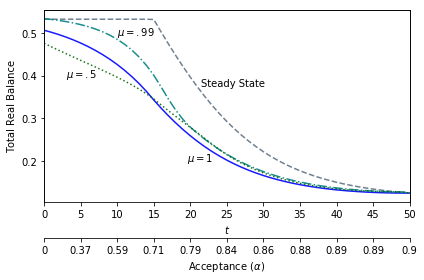

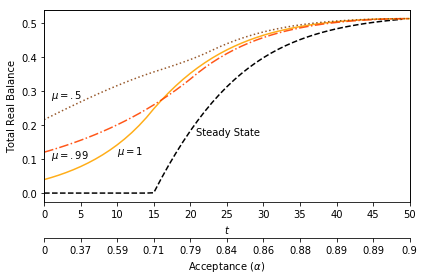

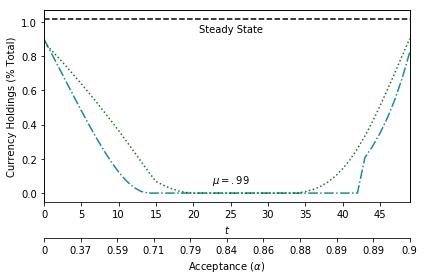

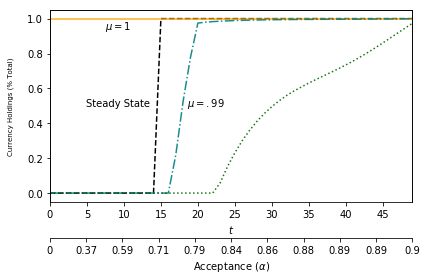

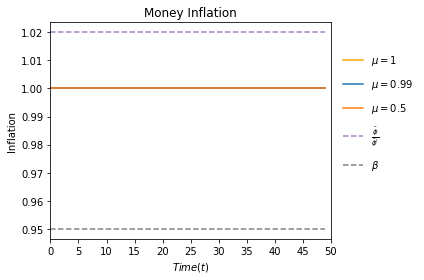

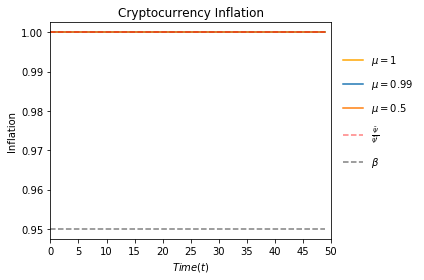

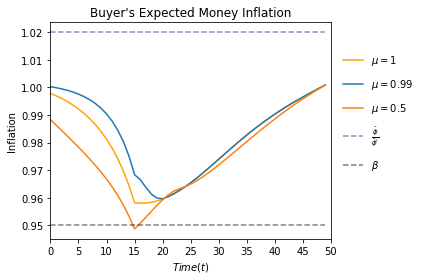

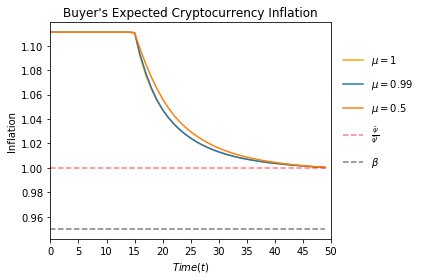

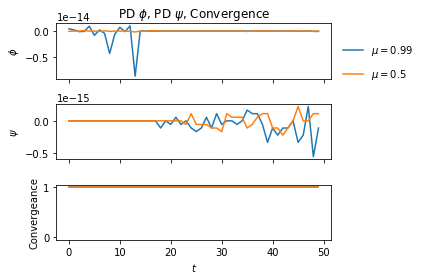

In [11]:
# See how total real balances and currency holding change with mu, including mu=0 from No Hodlers

lam = .5 # Meeting rate lambda (trying to get W to be increasing in alpha)
theta = .5 # Buyer bargaining power (trying to get W to be increasing in alpha)
eta = .3 # Buyer risk aversion (trying to get W to be increasing in alpha)

gammam = 0.02 # Money inflation rate
gammac = 0 # CC inflation rate

pi = .1 # Chance tomorrow low state
M0 = 1 # initial money supply
C0 = 1 # initial cc supply
trials = 400 # Number of iterations for good_guess (see above cell) 
T = 50
t = copy(T) # period counter

alphatop = .9
alpha0 = 0
delta = .1 # fraction of distance from alphatop grown each period
alphagrid = [alpha0] # first alpha
# Seems to be no convenient way to do math, just use recursion
for ind in range(T):
    alphagrid.append(delta * alphatop + (1 - delta) * alphagrid[ind])
    
# Allow mu to change and change how this is saved
# mugrid = [.99, .75, .5]
mugrid, periods = [.99, .5], "periods"
# mugrid, periods = [.99], "periods1"


# Choose colors for each line 
m_c_grid = ['teal', 'darkgreen']
c_c_grid = ['orangered', 'saddlebrown']
ls_grid = ['-.', ':']
c_ind = 0



# Track period t
tgrid = range(T + 1)
# Each period's currency supply
Mgrid = [round(M0 * (1 + gammam) ** i, 8) for i in range(T+1)]
Cgrid = [round(C0 * (1 + gammac) ** i, 8) for i in range(T+1)]
# Growing prices, price differences, and convergence
phigrid, psigrid = np.zeros(T + 1), np.zeros(T + 1) 
phidgrid, psidgrid, siggrid = np.zeros(T), np.zeros(T), np.zeros(T)
# Steady state prices
phisgrid, psisgrid = np.zeros(T), np.zeros(T)
# Growing total real balances
Trbphigrid, Trbpsigrid = np.zeros(T + 1), np.zeros(T + 1)
# Steady total real balances
Trbphisgrid, Trbpsisgrid = np.zeros(T), np.zeros(T)
# Buyer's and Hodlers' currency holdings
mgrid, cgrid, mhogrid, chogrid = np.zeros(T + 1), np.zeros(T + 1), np.zeros(T + 1), np.zeros(T + 1)
# Steady state currency hodlings
msgrid, csgrid = np.zeros(T), np.zeros(T)

# First graph mu = 1 (no hodlers)
while t >=1 : 
    
    if t == T: # If in highest period, prices in high state from highest st st
        ah = np.copy(alphagrid[t]) # alpha in highest state
        # This is the last high period
        M, C, Mp, Cp = np.copy(Mgrid[t - 1]), np.copy(Cgrid[t - 1]), np.copy(Mgrid[t]), np.copy(Cgrid[t]) 
        phih, psih = ststprices(ah, Mp, Cp, gammam, gammac, lam, theta, eta) # Prices in highest state
        Wh = ststW(ah, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta) # Value of highest state
        phigrid[t], psigrid[t] = np.copy(phih), np.copy(psih) # Prices if this state is reached
        Trbphigrid[t], Trbpsigrid[t] = np.copy(phih* M), np.copy(psih * C) # Total real balances if this state reached   
        mgrid[t], cgrid[t] = Mp * (phih > 0), Cp * (psih > 0) # Currency holdings
        
    t+=-1 # Working backwads
    al = np.copy(alphagrid[t]) # alpha in lowest state
    M, C, Mp, Cp = np.copy(Mgrid[t]), np.copy(Cgrid[t]), np.copy(Mgrid[t+1]), np.copy(Cgrid[t+1])
    phil, psil = ststprices(al, Mp, Cp, gammam, gammac, lam, theta, eta) # Prices in lowest state
    Wl = ststW(al, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta) # Value of lowest st st
    phisgrid[t], psisgrid[t] = np.copy(phil), np.copy(psil) # If this is st st
    msgrid[t], csgrid[t] = Mp * (phil > 0), Cp * (psil > 0) # Currency holdings in st st
    Trbphisgrid[t], Trbpsisgrid[t] = np.copy(phil * M), np.copy(psil * C) # If this is st st
    # Solve for today's prices/value
    phitemp, psitemp, Wtemp = nohperiod(
        M, C, 0, 0, al, phil, psil, Wl, ah, phih, psih, Wh, gammam=gammam, gammac=gammac, pi=pi) 
    phigrid[t], psigrid[t] = np.copy(phitemp), np.copy(psitemp)    
    mgrid[t], cgrid[t] = Mp * (phitemp > 0), Cp * (psitemp > 0) # Currency holdings 
    Trbphigrid[t], Trbpsigrid[t] = np.copy(phih * M), np.copy(psih * C)
    # Today's alpha/prices/value are yesterday's highest alpha/prices/value
    ah, phih, psih, Wh = np.copy(alphagrid[t]), np.copy(phitemp), np.copy(psitemp), np.copy(Wtemp) 

# Start graphing here
ticksize = T / 10   
xticks = [i * ticksize for i in range(11)]

# Graph total real balances of money  
figtrbm, axtrbm = plt.subplots()
axtrbm.plot(tgrid[:-1], Trbphisgrid, label=r"$\bar{\phi} M$", color="slategray", linestyle="--")
axtrbm.plot(tgrid, Trbphigrid, label=r"$\mu = 1$", color='blue', alpha=0.9)

# Graph total real balances of cryptocurrency 
figtrbc, axtrbc = plt.subplots()
axtrbc.plot(tgrid[:-1], Trbpsisgrid, label=r"$\bar{\psi} C$", color="black", linestyle="--")
axtrbc.plot(tgrid, Trbpsigrid, label=r"$\mu = 1$", color='orange', alpha=0.9)

# Currency Holdings (As percernt of total currency)
# Need to create these arrays first, as last period is same money base as second last period
cperC = np.asarray(cgrid) / np.asarray(Cgrid) / (1 + gammac)
cperC[T] = np.asarray(cgrid[T]) / np.asarray(Cgrid[T])

# Hodler money (just print st st for now)
figch, axch = plt.subplots() 
axch.plot(tgrid[:-1], np.asarray(msgrid) / np.asarray(Mgrid[:-1]), label=r"$\overline{m}$", color="black", linestyle="--")

# Buyer cryptocurrency
figch2, axch2 = plt.subplots()
axch2.plot(tgrid[:-1], np.asarray(csgrid) / np.asarray(Cgrid[:-1]), label=r"$\overline{c}$", color="black", linestyle="--")
axch2.plot(tgrid[:-1], cperC[:-1], label=r"$\mu = 1$", color='orange', alpha=0.9)

# Money inflation
phiinfgrid = np.asarray(phigrid[:-1]) / np.asarray(phigrid[:-1])

figim, axim = plt.subplots()    
axim.plot(tgrid[:-1], phiinfgrid, label=f"$\mu = 1$", color='orange')

# Cryptocurrency Inflation
psiinfgrid = np.asarray(psigrid[:-1]) / np.asarray(psigrid[:-1])

figic, axic = plt.subplots() 
axic.plot(tgrid[:-1], psiinfgrid, label=f"$\mu = 1$", color='orange')

# Expected Money inflation
phiEinfgrid = np.asarray(phigrid[:-1]) / ((1 - pi)*np.asarray(phigrid[:-1]) + pi*np.asarray(phisgrid))

figeim, axeim = plt.subplots()
axeim.plot(tgrid[:-1], phiEinfgrid, label=f"$\mu = 1$", color='orange')

# Expected Cryptocurrency Inflation
psiEinfgrid = np.asarray(psigrid[:-1]) / ((1 - pi)*np.asarray(psigrid[:-1]) + pi*np.asarray(psisgrid))

figeic, axeic = plt.subplots() 
axeic.plot(tgrid[:-1], psiEinfgrid, label=f"$\mu = 1$", color='orange')

# For mu != 1, check prices and make sure converged
figc, axc = plt.subplots(3, sharex=True)

# Now loop over mu, plotting results
for mu in mugrid:
    
    t = np.copy(T) # reset period counter
    
    # Copy code directly from above
    while t >= 1: 
        if t == T: # If in highest period, prices in high state from highest st st
            # Currency supplies today and tomorrow
            M, C, Mp, Cp = np.copy(Mgrid[t - 1]), np.copy(Cgrid[t - 1]), np.copy(Mgrid[t]), np.copy(Cgrid[t])
            ah = np.copy(alphagrid[t]) # alpha in highest state
            phih, psih = ststprices(ah, Mp, Cp, gammam, gammac, lam, theta, eta) # Prices in highest state
            Wh = ststW(ah, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta) # Welfare of highest state
            Whp, Whohp = copy(Wh), copy(Wh)
            # Prices and total real balances
            phigrid[T], psigrid[T] = np.copy(phih), np.copy(psih) 
            Trbphigrid[T], Trbpsigrid[T] = phih * M, psih * C
            # Buyer's and hodlers' currency holdings
            mgrid[T], mhogrid[T] = Mp * (phih > 0), Mp * (phih > 0)
            cgrid[T], chogrid[T] = Cp * (psih > 0), Cp * (psih > 0)

        t += - 1 # working backwards
        # Currency supplies
        M, C, Mp, Cp = np.copy(Mgrid[t]), np.copy(Cgrid[t]), np.copy(Mgrid[t+1]), np.copy(Cgrid[t+1])
        al = np.copy(alphagrid[t]) # alpha in lower state
        phil, psil = ststprices(al, Mp, Cp, gammam, gammac, lam, theta, eta) # Prices in lower state
        Wlp = ststW(al, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta) # Value of lower steady state
        Wholp = copy(Wlp) # Hodler's low continuation value equal to this st st
        # Solve for today's prices/value
        guessm, guessc = good_guess(
            M, C, pi, al, ah, phil, psil, phih, psih, Wlp, Wholp, Whp, Whohp, mu, theta, lam, eta, trials)
        (phi, phib, phiho, psi, psib, psiho, m, mho, c, cho, qbl, qml, qbh, qmh, qhobl, qhoml, qhobh, qhomh, 
                W, Wl, Wh, Who, Whol, Whoh, sig)= period_outcomes(
            M, C, pi, al, ah, phil, psil, phih, psih, Wlp, Wholp, Whp, Whohp, mu, theta, lam, eta, guessm, guessc)
        # Prices and price differences
        phigrid[t], psigrid[t] = np.copy(phi), np.copy(psi) 
        phidgrid[t], psidgrid[t] = phib - phiho, psib - psiho
        # Total real balances
        Trbphigrid[t], Trbpsigrid[t] = phi * M, psi * C
        # Check if convereged
        siggrid[t] = np.copy(sig)  
        # Buyer and Hodler currency holdings
        mgrid[t], cgrid[t], mhogrid[t], chogrid[t] = np.copy(m), np.copy(c), np.copy(mho), np.copy(cho)
        # Today's alpha/prices/welfare are yesterday's higher alpha/prices/value
        ah, phih, psih = np.copy(alphagrid[t]), np.copy(phi), np.copy(psi)
        Whp, Whohp = np.copy(W), np.copy(Who)
        
    # Graph results

    # Graph total real balances of money  
    axtrbm.plot(tgrid, Trbphigrid, label=f"$\mu = {mu}$", color=m_c_grid[c_ind], ls=ls_grid[c_ind], alpha=0.9)

    # Graph total real balances of cryptocurrency
    axtrbc.plot(tgrid, Trbpsigrid, label=f"$\mu = {mu}$", color=c_c_grid[c_ind], ls=ls_grid[c_ind], alpha=0.9)

    # Currency Holdings (As percernt of total currency)
    # Need to create these arrays first, as last period is same money base as second last period
    mhoperM = np.asarray(mhogrid) / np.asarray(Mgrid) / (1 + gammam)
    mhoperM[T] = np.asarray(mhogrid[T]) / np.asarray(Mgrid[T])
    cperC = np.asarray(cgrid) / np.asarray(Cgrid) / (1 + gammac)
    cperC[T] = np.asarray(cgrid[T]) / np.asarray(Cgrid[T])

    # Hodler money 
    axch.plot(tgrid[:-1], mhoperM[:-1], label=f"$\mu = {mu}$", color=m_c_grid[c_ind], ls=ls_grid[c_ind], alpha=0.9)

    # Buyer cryptocurrency
    axch2.plot(tgrid[:-1], cperC[:-1], label=f"$\mu = {mu}$", color=m_c_grid[c_ind], ls=ls_grid[c_ind], alpha=0.9)
    
    # Money Inflation
    phiinfgrid = np.asarray(phigrid[:-1]) / np.asarray(phigrid[:-1])
    
    axim.plot(tgrid[:-1], phiinfgrid, label=f"$\mu = {mu}$")
    
    # Cryptocurrency Inflation
    psiinfgrid = np.asarray(psigrid[:-1]) / np.asarray(psigrid[:-1])
    
    axic.plot(tgrid[:-1], psiinfgrid, label=f"$\mu = {mu}$")
    
    # Expected Money Inflation
    phiEinfgrid = np.asarray(phigrid[:-1]) / ((1 - pi)*np.asarray(phigrid[:-1]) + pi*np.asarray(phisgrid))
    
    axeim.plot(tgrid[:-1], phiEinfgrid, label=f"$\mu = {mu}$")
    
    # Expected Cryptocurrency Inflation
    psiEinfgrid = np.asarray(psigrid[:-1]) / ((1 - pi)*np.asarray(psigrid[:-1]) + pi*np.asarray(psisgrid))
    
    axeic.plot(tgrid[:-1], psiEinfgrid, label=f"$\mu = {mu}$")

    # For mu != 1, check prices and make sure converged
    axc[0].plot(tgrid[:T], phidgrid, label=f"$\mu = {mu}$")
    axc[1].plot(tgrid[:T], psidgrid, label=f"$\mu = {mu}$")
    axc[2].plot(tgrid[:T], siggrid, label=f"$\mu = {mu}$")
    
    c_ind += 1
    
# Finish graphing

# Graph total real balances of money 
axtrbm.text(21.5, .375, 'Steady State')
axtrbm.text(19.5, .2, '$\mu = 1$')
axtrbm.text(10, .495, '$\mu = .99$')
# axtrbm.text(25, .445, '$\mu = .75$')
axtrbm.text(3, .395, '$\mu = .5$')
# axtrbm.plot([10, 24.5], [.45, .45], linestyle = ':', alpha=.75, color="green")
axtrbm.autoscale(enable=True, axis='x', tight=True)
axtrbm.set_xticks(xticks)
#lgd0m = axtrbm.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .8))
# axtrbm.set_title(r"Money Total Real Balances")
axtrbm.set_xlabel(r"$t$")
axtrbm.set_ylabel(r"Total Real Balance")
# Make another x scale based on alpha
axtrbma = axtrbm.twiny()
axtrbma.set_xticks(xticks)
axtrbma.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axtrbma.set_xlabel(r"Acceptance ($\alpha$)")
axtrbma.xaxis.set_ticks_position('bottom')
axtrbma.xaxis.set_label_position('bottom')
axtrbma.spines['bottom'].set_position(('outward', 36))

figtrbm.tight_layout()
add0m = r"\changemu\\" + str(T) + periods + "trbm.pdf" 
# figtrbm.savefig(file + add0m, bbox_extra_artists=(lgd0m,), bbox_inches='tight')
figtrbm.savefig(file + add0m)
# figtrbm.close()

# Graph total real balances of cryptocurrency 
axtrbc.text(20.75, .17, 'Steady State')
axtrbc.text(10, .115, '$\mu = 1$')
axtrbc.text(1, .1025, '$\mu = .99$')
# axtrbc.text(1, .195, '$\mu = .75$')
axtrbc.text(1, .28, '$\mu = .5$')
axtrbc.autoscale(enable=True, axis='x', tight=True)
axtrbc.set_xticks(xticks)
#lgd0c = axtrbc.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .8))
# axtrbc.set_title(r"Cryptocurrency Total Real Balances")
axtrbc.set_xlabel(r"$t$")
axtrbc.set_ylabel(r"Total Real Balance")
# Make another x scale based on alpha
axtrbca = axtrbc.twiny()
axtrbca.set_xticks(xticks)
axtrbca.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axtrbca.set_xlabel(r"Acceptance ($\alpha$)")
axtrbca.xaxis.set_ticks_position('bottom')
axtrbca.xaxis.set_label_position('bottom')
axtrbca.spines['bottom'].set_position(('outward', 36))

figtrbc.tight_layout()
add0c = r"\changemu\\" + str(T) + periods + "trbc.pdf"
# figtrbc.savefig(file + add0c, bbox_extra_artists=(lgd0c,), bbox_inches='tight')
figtrbc.savefig(file + add0c)
# figtrbc.close()

# Hodler money (just print st st for now)
axch.text(25, .94, 'Steady State', ha='center')
axch.text(25, .06, '$\mu = .99$', ha='center')
axch.autoscale(enable=True, axis='x', tight=True)
axch.set_xticks(xticks[:-1])
#lgd1 = axch.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .8))
axch.set_ylabel(r"Currency Holdings (% Total)")
# axch.set_title(f"Hodler Money Holdings (Percent of Total)")
axch.set_xlabel(r"$t$")
# Make another x scale based on alpha
axcha = axch.twiny()
axcha.set_xticks(xticks)
axcha.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axcha.set_xlabel(r"Acceptance ($\alpha$)")
axcha.xaxis.set_ticks_position('bottom')
axcha.xaxis.set_label_position('bottom')
axcha.spines['bottom'].set_position(('outward', 36))

add1 = r"\changemu\\" + str(T) + periods + "hom.pdf"
figch.tight_layout()
#figch.savefig(file + add1, bbox_extra_artists=(lgd1,), bbox_inches='tight')
figch.savefig(file + add1)
# figch.close()

# Buyer cryptocurrency
axch2.text(13.5, .5, 'Steady State', ha='right')
axch2.text(7.5, .94, '$\mu = 1$')
axch2.text(18.5, .5, '$\mu = .99$')
axch2.set_ylabel(r"Currency Holdings (% Total)", fontsize=7)
axch2.autoscale(enable=True, axis='x', tight=True)
axch2.set_xticks(xticks[:-1])
axch2.get_yaxis().set_label_coords(-0.1,0.5)
axch2.set_xlabel(r"$t$")
# axch2.set_title(f"Buyer Cryptocurrency Holdings (Percent of Total)")
# lgd1b = axch2.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .8))
# Make another x scale based on alpha
axch2a = axch2.twiny()
axch2a.set_xticks(xticks)
axch2a.set_xticklabels([round(alphagrid[int(x)], 2) for x in xticks])
axch2a.set_xlabel(r"Acceptance ($\alpha$)")
axch2a.xaxis.set_ticks_position('bottom')
axch2a.xaxis.set_label_position('bottom')
axch2a.spines['bottom'].set_position(('outward', 36))

add1b = r"\changemu\\" + str(T) + periods + "c.pdf"
figch2.tight_layout()
#figch2.savefig(file + add1b, bbox_extra_artists=(lgd1b,), bbox_inches='tight')
figch2.savefig(file + add1b)
# figch2.close()

# Money Inflation
axim.plot(tgrid[:-1], (1 + gammam) * np.ones(len(tgrid) - 1), 
         label=r"$\frac{\bar{\phi}}{\bar{\phi}'}$", color='indigo', alpha=.5, linestyle = '--')
axim.plot(tgrid[:-1], B * np.ones(len(tgrid) - 1), 
         label=r"$\beta$", color='black', alpha=.5, linestyle = '--')
axim.autoscale(enable=True, axis='x', tight=True)
axim.set_xticks(xticks)
lgd3 = axim.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .9))
axim.set_title(r"Money Inflation")
axim.set_xlabel(r"$Time (t)$")
axim.set_ylabel(r"Inflation")

figim.tight_layout()
add3 = r"\changemu\\" + str(T)+ periods + "minf.pdf"
figim.savefig(file + add3, bbox_extra_artists=(lgd3,), bbox_inches='tight')
#figim.close()

# Cryptocurrency Inflation
axic.plot(tgrid[:-1], (1 + gammac) * np.ones(len(tgrid) - 1), 
          label=r"$\frac{\bar{\psi}}{\bar{\psi}'}$", color='red', alpha=.5, linestyle = '--')
axic.plot(tgrid[:-1], B * np.ones(len(tgrid) - 1), 
         label=r"$\beta$", color='black', alpha=.5, linestyle = '--')
axic.autoscale(enable=True, axis='x', tight=True)
axic.set_xticks(xticks)
lgd3b = axic.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .9))
axic.set_title(r"Cryptocurrency Inflation")
axic.set_xlabel(r"$Time (t)$")
axic.set_ylabel(r"Inflation")

figic.tight_layout()
add3b = r"\changemu\\" + str(T) + periods + "cinf.pdf"
figic.savefig(file + add3b, bbox_extra_artists=(lgd3b,), bbox_inches='tight')
#figic.close()

# Expected Money Inflation
axeim.plot(tgrid[:-1], (1 + gammam) * np.ones(len(tgrid) - 1), 
         label=r"$\frac{\bar{\phi}}{\bar{\phi}'}$", color='indigo', alpha=.5, linestyle = '--')
axeim.plot(tgrid[:-1], B * np.ones(len(tgrid) - 1), 
         label=r"$\beta$", color='black', alpha=.5, linestyle = '--')
axeim.autoscale(enable=True, axis='x', tight=True)
axeim.set_xticks(xticks)
lgd3e = axeim.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .9))
axeim.set_title(r"Buyer's Expected Money Inflation")
axeim.set_xlabel(r"$Time (t)$")
axeim.set_ylabel(r"Inflation")

figeim.tight_layout()
add3e = r"\changemu\\" + str(T) + periods + "Eminf.pdf"
figeim.savefig(file + add3e, bbox_extra_artists=(lgd3e,), bbox_inches='tight')
#figeim.close()

# Expected Cryptocurrency Inflation
axeic.plot(tgrid[:-1], (1 + gammac) * np.ones(len(tgrid) - 1), 
         label=r"$\frac{\bar{\psi}}{\bar{\psi}'}$", color='red', alpha=.5, linestyle = '--')
axeic.plot(tgrid[:-1], B * np.ones(len(tgrid) - 1), 
         label=r"$\beta$", color='black', alpha=.5, linestyle = '--')
axeic.autoscale(enable=True, axis='x', tight=True)
axeic.set_xticks(xticks)
lgd3be = axeic.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .9))
axeic.set_title(r"Buyer's Expected Cryptocurrency Inflation")
axeic.set_xlabel(r"$Time (t)$")
axeic.set_ylabel(r"Inflation")

figeic.tight_layout()
add3be = r"\changemu\\" + str(T) + periods + "Ecinf.pdf"
figeic.savefig(file + add3be, bbox_extra_artists=(lgd3be,), bbox_inches='tight')
#figeic.close()

# For mu != 1, check prices and make sure converged
axc[0].legend()
axc[0].set_title(r"PD $\phi$, PD $\psi$, Convergence")
axc[0].set_ylabel(r"$\phi$")
axc[1].set_ylabel(r"$\psi$")
axc[2].set_xlabel(r"$t$")
axc[2].set_ylabel(r"Convergeance")
axc[2].set_ylim(-.05,1.05)
lgd2 = axc[0].legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .8))

figc.tight_layout()
add2 = r"\changemu\\" + str(T) + periods + "check.pdf"
figc.savefig(file + add2, bbox_extra_artists=(lgd2,), bbox_inches='tight')
# figc.close()

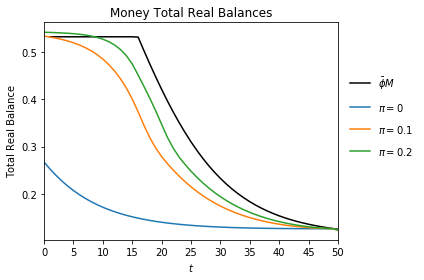

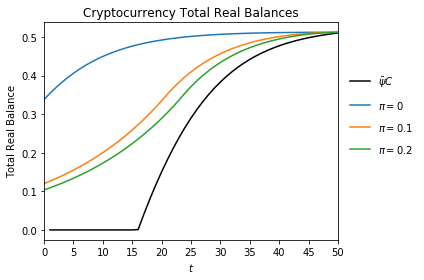

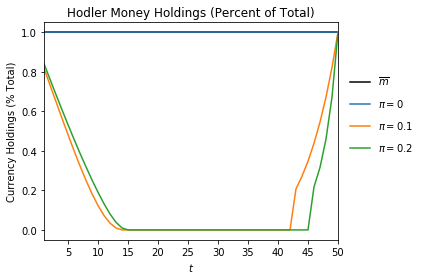

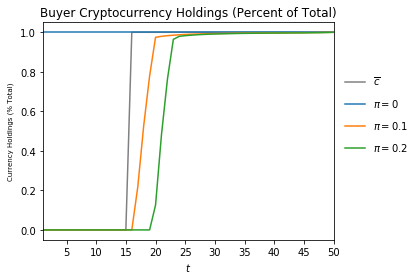

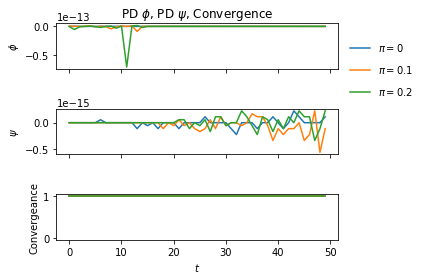

In [5]:
# See how total real balances and currency holding change with pi

lam = .5 # Meeting rate lambda (trying to get W to be increasing in alpha)
theta = .5 # Buyer bargaining power (trying to get W to be increasing in alpha)
eta = .3 # Buyer risk aversion (trying to get W to be increasing in alpha)

gammam = 0.02 # Money inflation rate
gammac = 0 # CC inflation rate

mu = .99 # measure of buyers
M0 = 1 # initial money supply
C0 = 1 # initial cc supply
trials = 400 # Number of iterations for good_guess (see above cell) 
T = 50
t = copy(T) # period counter

alphatop = .9
alpha0 = 0
delta = .1 # fraction of distance from alphatop grown each period
alphagrid = [alpha0] # first alpha
# Seems to be no convenient way to do math, just use recursion
for ind in range(T):
    alphagrid.append(delta * alphatop + (1 - delta) * alphagrid[ind])
    
# Allow pi to change
pigrid = [0, .1, .2]


# Track period t
tgrid = range(T + 1)
# Each period's currency supply
Mgrid = [round(M0 * (1 + gammam) ** i, 8) for i in range(T+1)]
Cgrid = [round(C0 * (1 + gammac) ** i, 8) for i in range(T+1)]
# Growing prices, price differences, and convergence
phigrid, psigrid = np.zeros(T + 1), np.zeros(T + 1) 
phidgrid, psidgrid, siggrid = np.zeros(T), np.zeros(T), np.zeros(T)
# Steady state prices
phisgrid, psisgrid = np.zeros(T), np.zeros(T)
# Growing total real balances
Trbphigrid, Trbpsigrid = np.zeros(T + 1), np.zeros(T + 1)
# Steady total real balances
Trbphisgrid, Trbpsisgrid = np.zeros(T), np.zeros(T)
# Buyer's and Hodlers' currency holdings
mgrid, cgrid, mhogrid, chogrid = np.zeros(T + 1), np.zeros(T + 1), np.zeros(T + 1), np.zeros(T + 1)
# Steady state currency hodlings
msgrid, csgrid = np.zeros(T), np.zeros(T)

# Use this code for st st values
while t >=1 : 
    
    if t == T: # If in highest period, prices in high state from highest st st
        ah = np.copy(alphagrid[t]) # alpha in highest state
        # This is the last high period
        M, C, Mp, Cp = np.copy(Mgrid[t - 1]), np.copy(Cgrid[t - 1]), np.copy(Mgrid[t]), np.copy(Cgrid[t]) 
        phih, psih = ststprices(ah, Mp, Cp, gammam, gammac, lam, theta, eta) # Prices in highest state
        Wh = ststW(ah, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta) # Value of highest state
        phigrid[t], psigrid[t] = np.copy(phih), np.copy(psih) # Prices if this state is reached
        Trbphigrid[t], Trbpsigrid[t] = np.copy(phih* M), np.copy(psih * C) # Total real balances if this state reached   
        mgrid[t], cgrid[t] = Mp * (phih > 0), Cp * (psih > 0) # Currency holdings
        
    t+=-1 # Working backwads
    al = np.copy(alphagrid[t]) # alpha in lowest state
    M, C, Mp, Cp = np.copy(Mgrid[t]), np.copy(Cgrid[t]), np.copy(Mgrid[t+1]), np.copy(Cgrid[t+1])
    phil, psil = ststprices(al, Mp, Cp, gammam, gammac, lam, theta, eta) # Prices in lowest state
    Wl = ststW(al, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta) # Value of lowest st st
    phisgrid[t], psisgrid[t] = np.copy(phil), np.copy(psil) # If this is st st
    msgrid[t], csgrid[t] = Mp * (phil > 0), Cp * (psil > 0) # Currency holdings in st st
    Trbphisgrid[t], Trbpsisgrid[t] = np.copy(phil* M), np.copy(psil * C) # If this is st st
    # Solve for today's prices/value
    phitemp, psitemp, Wtemp = nohperiod(
        M, C, 0, 0, al, phil, psil, Wl, ah, phih, psih, Wh, gammam=gammam, gammac=gammac, pi=pi) 
    phigrid[t], psigrid[t] = np.copy(phitemp), np.copy(psitemp)    
    mgrid[t], cgrid[t] = Mp * (phitemp > 0), Cp * (psitemp > 0) # Currency holdings 
    Trbphigrid[t], Trbpsigrid[t] = np.copy(phih * M), np.copy(psih * C)
    # Today's alpha/prices/value are yesterday's highest alpha/prices/value
    ah, phih, psih, Wh = np.copy(alphagrid[t]), np.copy(phitemp), np.copy(psitemp), np.copy(Wtemp) 

# Start graphing here
# Only steady state now
ticksize = T / 10   
xticks = [i * ticksize for i in range(11)]

# Graph total real balances of money  
figtrbm, axtrbm = plt.subplots()
axtrbm.plot(tgrid[:-1], Trbphisgrid, label=r"$\bar{\phi} M$", color="black")

# Graph total real balances of cryptocurrency 
figtrbc, axtrbc = plt.subplots()
axtrbc.plot(tgrid[:-1], Trbpsisgrid, label=r"$\bar{\psi} C$", color="black")

# Hodler money 
figch, axch = plt.subplots() 
axch.plot(tgrid[:-1], np.asarray(msgrid) / np.asarray(Mgrid[:-1]), label=r"$\overline{m}$", color="black")

# Buyer cryptocurrency
figch2, axch2 = plt.subplots()
axch2.plot(tgrid[:-1], np.asarray(csgrid) / np.asarray(Cgrid[:-1]), label=r"$\overline{c}$", color="gray")

# For mu != 1, check prices and make sure converged
figc, axc = plt.subplots(3, sharex=True) 

# Now loop over mu, plotting results
for pi in pigrid:
    
    t = np.copy(T) # reset period counter
    
    # Copy code directly from above
    while t >= 1: 
        if t == T: # If in highest period, prices in high state from highest st st
            # Currency supplies today and tomorrow
            M, C, Mp, Cp = np.copy(Mgrid[t - 1]), np.copy(Cgrid[t - 1]), np.copy(Mgrid[t]), np.copy(Cgrid[t])
            ah = np.copy(alphagrid[t]) # alpha in highest state
            phih, psih = ststprices(ah, Mp, Cp, gammam, gammac, lam, theta, eta) # Prices in highest state
            Wh = ststW(ah, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta) # Welfare of highest state
            Whp, Whohp = copy(Wh), copy(Wh)
            # Prices and total real balances
            phigrid[T], psigrid[T] = np.copy(phih), np.copy(psih) 
            Trbphigrid[T], Trbpsigrid[T] = phih * M, psih * C
            # Buyer's and hodlers' currency holdings
            mgrid[T], mhogrid[T] = Mp * (phih > 0), Mp * (phih > 0)
            cgrid[T], chogrid[T] = Cp * (psih > 0), Cp * (psih > 0)

        t += - 1 # working backwards
        # Currency supplies
        M, C, Mp, Cp = np.copy(Mgrid[t]), np.copy(Cgrid[t]), np.copy(Mgrid[t+1]), np.copy(Cgrid[t+1])
        al = np.copy(alphagrid[t]) # alpha in lower state
        phil, psil = ststprices(al, Mp, Cp, gammam, gammac, lam, theta, eta) # Prices in lower state
        Wlp = ststW(al, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta) # Value of lower steady state
        Wholp = copy(Wlp) # Hodler's low continuation value equal to this st st
        # Solve for today's prices/value
        guessm, guessc = good_guess(
            M, C, pi, al, ah, phil, psil, phih, psih, Wlp, Wholp, Whp, Whohp, mu, theta, lam, eta, trials)
        (phi, phib, phiho, psi, psib, psiho, m, mho, c, cho, qbl, qml, qbh, qmh, qhobl, qhoml, qhobh, qhomh, 
                W, Wl, Wh, Who, Whol, Whoh, sig)= period_outcomes(
            M, C, pi, al, ah, phil, psil, phih, psih, Wlp, Wholp, Whp, Whohp, mu, theta, lam, eta, guessm, guessc)
        # Prices and price differences
        phigrid[t], psigrid[t] = np.copy(phi), np.copy(psi) 
        phidgrid[t], psidgrid[t] = phib - phiho, psib - psiho
        # Total real balances
        Trbphigrid[t], Trbpsigrid[t] = phi * M, psi * C
        # Check if convereged
        siggrid[t] = np.copy(sig)  
        # Buyer and Hodler currency holdings
        mgrid[t], cgrid[t], mhogrid[t], chogrid[t] = np.copy(m), np.copy(c), np.copy(mho), np.copy(cho)
        # Today's alpha/prices/welfare are yesterday's higher alpha/prices/value
        ah, phih, psih = np.copy(alphagrid[t]), np.copy(phi), np.copy(psi)
        Whp, Whohp = np.copy(W), np.copy(Who)
        
    # Graph results

    # Graph total real balances of money  
    axtrbm.plot(tgrid, Trbphigrid, label=f"$\pi = {pi}$")

    # Graph total real balances of cryptocurrency
    axtrbc.plot(tgrid, Trbpsigrid, label=f"$\pi = {pi}$")

    # Currency Holdings (As percernt of total currency)
    # Need to create these arrays first, as last period is same money base as second last period
    mhoperM = np.asarray(mhogrid) / np.asarray(Mgrid) / (1 + gammam)
    mhoperM[T] = np.asarray(mhogrid[T]) / np.asarray(Mgrid[T])
    cperC = np.asarray(cgrid) / np.asarray(Cgrid) / (1 + gammac)
    cperC[T] = np.asarray(cgrid[T]) / np.asarray(Cgrid[T])

    # Hodler money 
    axch.plot(tgrid[:-1], mhoperM[:-1], label=f"$\pi = {pi}$")

    # Buyer cryptocurrency
    axch2.plot(tgrid[:-1], cperC[:-1], label=f"$\pi = {pi}$")

    # For mu != 1, check prices and make sure converged
    axc[0].plot(tgrid[:T], phidgrid, label=f"$\pi = {pi}$")
    axc[1].plot(tgrid[:T], psidgrid, label=f"$\pi = {pi}$")
    axc[2].plot(tgrid[:T], siggrid, label=f"$\pi = {pi}$")
    
# Finish graphing
# Graph total real balances of money 
axtrbm.autoscale(enable=True, axis='x', tight=True)
axtrbm.set_xticks(xticks)
lgd0m = axtrbm.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .8))
axtrbm.set_title(r"Money Total Real Balances")
axtrbm.set_xlabel(r"$t$")
axtrbm.set_ylabel(r"Total Real Balance")

figtrbm.tight_layout()
add0m = r"\changepi\\" + str(T) + "periodstrbm.pdf"
figtrbm.savefig(file + add0m, bbox_extra_artists=(lgd0m,), bbox_inches='tight')
# figtrbm.close()

# Graph total real balances of cryptocurrency 
axtrbc.autoscale(enable=True, axis='x', tight=True)
axtrbc.set_xticks(xticks)
lgd0c = axtrbc.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .8))
axtrbc.set_title(r"Cryptocurrency Total Real Balances")
axtrbc.set_xlabel(r"$t$")
axtrbc.set_ylabel(r"Total Real Balance")

figtrbc.tight_layout()
add0c = r"\changepi\\" + str(T) + "periodstrbc.pdf"
figtrbc.savefig(file + add0c, bbox_extra_artists=(lgd0c,), bbox_inches='tight')
# figtrbc.close()

# Hodler money (just print st st for now)
axch.autoscale(enable=True, axis='x', tight=True)
axch.set_xticks(xticks[:-1])
lgd1 = axch.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .8))
axch.set_ylabel(r"Currency Holdings (% Total)")
axch.set_title(f"Hodler Money Holdings (Percent of Total)")
axch.set_xlabel(r"$t$")

add1 = r"\changepi\\" + str(T) + "periodshom.pdf"
figch.tight_layout()
figch.savefig(file + add1, bbox_extra_artists=(lgd1,), bbox_inches='tight')
# figch.close()

# Buyer cryptocurrency
axch2.set_ylabel(r"Currency Holdings (% Total)", fontsize=7)
axch2.autoscale(enable=True, axis='x', tight=True)
axch2.set_xticks(xticks[:-1])
axch2.get_yaxis().set_label_coords(-0.1,0.5)
axch2.set_xlabel(r"$t$")
axch2.set_title(f"Buyer Cryptocurrency Holdings (Percent of Total)")
lgd1b = axch2.legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .8))

add1b = r"\changepi\\" + str(T) + "periodsc.pdf"
figch2.tight_layout()
figch2.savefig(file + add1b, bbox_extra_artists=(lgd1b,), bbox_inches='tight')
# figch2.close()

# For mu != 1, check prices and make sure converged
axc[0].legend()
axc[0].set_title(r"PD $\phi$, PD $\psi$, Convergence")
axc[0].set_ylabel(r"$\phi$")
axc[1].set_ylabel(r"$\psi$")
axc[2].set_xlabel(r"$t$")
axc[2].set_ylabel(r"Convergeance")
axc[2].set_ylim(-.05,1.05)
lgd2 = axc[0].legend(scatterpoints=1, frameon=False, labelspacing=1, loc=2, bbox_to_anchor=(1.01, .8))

figc.tight_layout()
add2 = r"\changepi\\" + str(T) + "periodscheck.pdf"
figc.savefig(file + add2, bbox_extra_artists=(lgd2,), bbox_inches='tight')
# figc.close()

In [27]:
%debug

> c:\users\spspi\anaconda3\lib\site-packages\matplotlib\axes\_base.py(242)_xy_from_xy()
    240         if x.shape[0] != y.shape[0]:
    241             raise ValueError("x and y must have same first dimension, but "
--> 242                              "have shapes {} and {}".format(x.shape, y.shape))
    243         if x.ndim > 2 or y.ndim > 2:
    244             raise ValueError("x and y can be no greater than 2-D, but have "

ipdb> u
> c:\users\spspi\anaconda3\lib\site-packages\matplotlib\axes\_base.py(383)_plot_args()
    381             x, y = index_of(tup[-1])
    382 
--> 383         x, y = self._xy_from_xy(x, y)
    384 
    385         if self.command == 'plot':

ipdb> u
> c:\users\spspi\anaconda3\lib\site-packages\matplotlib\axes\_base.py(406)_grab_next_args()
    404                 this += args[0],
    405                 args = args[1:]
--> 406             for seg in self._plot_args(this, kwargs):
    407                 yield seg
    408 

ipdb> u
*** Oldest frame
ipdb>

In [127]:
# Test these out
M = 1 # Original money supply
C = 1 # Original cc supply
pi = .1 # Chance tomorrow is low state
# gammam = .02 # inflation of money
# gammac = 0 # inflation of cc
mu = .99 # share of buyers (vs hodlers)
alphal = (gammac + 1 - B) / (gammam + 1 - B) + .05 # Slightly above indifference condition
alphah = (1 + alphal) / 2 # Don't want it to be 1, or money is not valued
Mp = M * (1 + gammam) # the money supply next period
Cp = C * (1 + gammac) # the cc supply next period
guessm, guessc = Mp / mu, Cp / mu
phil, psil = ststprices(alphal, Mp, Cp, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta) # prices in low stst
Wlp = ststW(alphal, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta)
Wholp = ststW(alphal, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta)
phih, psih = ststprices(alphah, Mp, Cp, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta) # prices in high stst
Whp = ststW(alphah, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta)
Whohp = ststW(alphah, gammam=gammam, gammac=gammac, lam=lam, theta=theta, eta=eta)

eta = .7
lam = .5
theta = .5
print(period_outcomes(M, C, pi, alphal, alphah, phil, psil, phih, psih, Wlp, Wholp, Whp, Whohp, mu, guessm, guessc))
print(good_guess(M, C, pi, alphal, alphah, phil, psil, phih, psih, Wlp, Wholp, Whp, Whohp, mu, theta, lam, eta, 251))

(56.06621244691445, 111.07394364439459, 1.0584812494343017, 20.215667539014415, 39.83808029164599, 0.5932547863828446, 1.8079726308119182e-08, 104.99999821010701, 4.528847415416854e-08, 99.99999551644096, 2.5533040722629326e-07, 2.272478501410909e-07, 3.69224679839821e-07, 1.7407535699819751e-07, 0.999999, 0.999999, 0.999999, 0.999999, 2.10365464664285, 2.2241193380484408, 2.0902696809311174, -7735.70817857741, -7747.14153568286, -7735.70817857741, True)
(1.0101010101010102, 0.0)


> <ipython-input-49-f34044aa648e>(18)sysc0()
     16             pi * phil * (1 + lam * liquidity(phil * x[0]), eta) + (1 - pi) * phih * (1 + lam * liquidity(phih*x[0], eta))
     17             - phih * (1 + lambh * liquidity(phih * mho + psih * cho, eta) + lammh * liquidity(phih * mho, eta))
---> 18             + pen * np.asarray(x[0] <= 0 or mho <= 0)
     19         )
     20     def jac0(x): # Derivative of sysc0 wrt m (x[0])

ipdb> pi * phil * (1 + lam * liquidity(phil * x[0]), eta) + (1 - pi) * phih * (1 + lam * liquidity(phih*x[0], eta))             - phih * (1 + lambh * liquidity(phih * mho + psih * cho, eta) + lammh * liquidity(phih * mho, eta))              + pen * np.asarray(x[0] <= 0 or mho <= 0)
*** TypeError: can't multiply sequence by non-int of type 'float'
ipdb> type(liquidity(phil * x[0]), eta))
*** SyntaxError: invalid syntax
ipdb> type(liquidity(phil * x[0], eta))
<class 'float'>
ipdb> exit
